## Compose

In [1]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

from sim.netrual import Component, NLT_reserve, NLT_components, NLT_accounts, NLT_REWARD  # noqa
from sim.data import get_batch_price, get_price, read_csv, format_ts as t
import pandas as pd
target = ['EOS', 'MANA', 'OMG', 'VEN', 'BNB', 'IOTA', 'ETH', 'BAT']
market_prices = get_batch_price(target)
m = market_prices.dropna()


In [2]:
# get_price('EOS')
m

,EOS,timestamp,MANA,OMG,VEN,BNB,IOTA,ETH,BAT
0,1.583040,1.502942e+09,0.016162,13.695406,0.165545,1.337833,0.301110,301.13,0.159207
1,1.570162,1.502943e+09,0.018768,13.124210,0.278916,1.315363,0.601720,298.00,0.162557
2,1.568672,1.502943e+09,0.018642,13.423960,0.267273,1.321293,7.532500,298.00,0.156335
3,1.579582,1.502943e+09,0.017574,13.332000,0.267614,1.332585,0.602823,299.05,0.144399
4,1.582127,1.502944e+09,0.017585,13.337114,0.254227,1.337267,1.109667,300.10,0.145095
5,1.578085,1.502944e+09,0.017106,13.014985,0.263869,1.326687,0.606531,299.39,0.153978
6,1.578085,1.502944e+09,0.017151,13.014077,0.263878,1.332956,0.840728,299.39,0.153782
7,1.578892,1.502944e+09,0.016509,12.711720,0.254201,1.341471,0.840728,299.60,0.153493
8,1.578892,1.502945e+09,0.016587,12.726000,0.249340,1.357649,0.779688,299.60,0.152484
9,1.582155,1.502945e+09,0.016481,12.746160,0.247248,1.366627,0.776776,300.79,0.146809


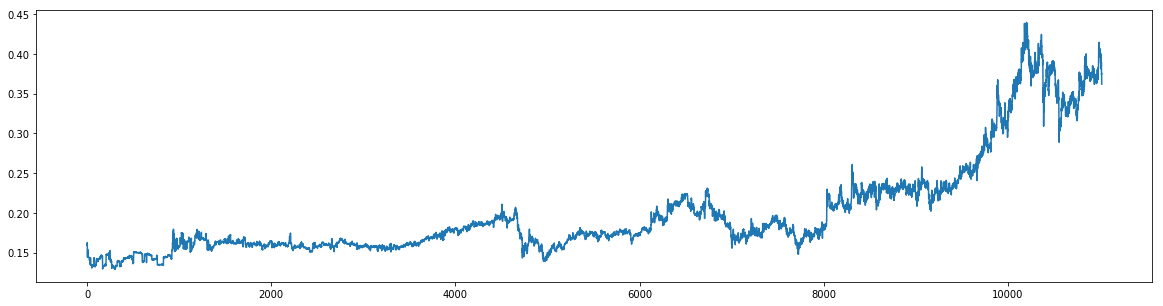

In [34]:
m.BAT.plot(x='timestamp', figsize=(20, 5))

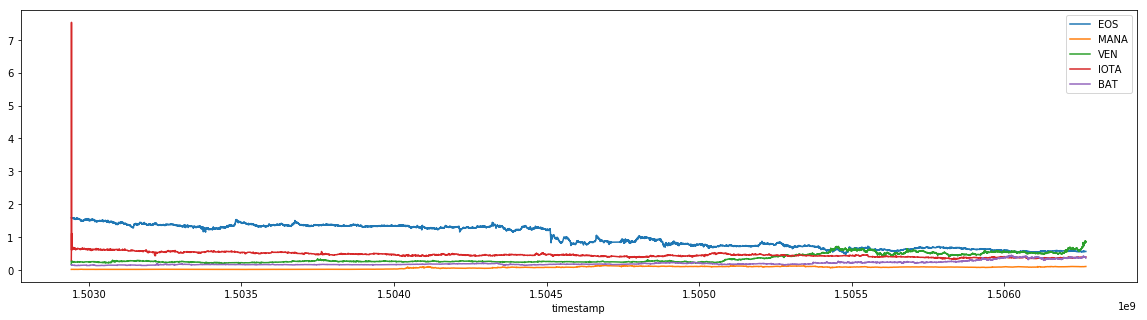

In [35]:
m.drop(columns=['ETH', 'OMG', 'BNB']).plot(x='timestamp', figsize=(20, 5))

In [4]:
tokens = [t for t in market_prices.columns if t != 'timestamp']
[Component(t) for t in tokens] 

[0.0 EOS => 0 NTL,
 0.0 MANA => 0 NTL,
 0.0 OMG => 0 NTL,
 0.0 VEN => 0 NTL,
 0.0 BNB => 0 NTL,
 0.0 IOTA => 0 NTL,
 0.0 ETH => 0 NTL,
 0.0 BAT => 0 NTL]

### Warmup with rational auction on fixed price

In [5]:
def rational_warmup(timestamp, market_price, sender, inital_price):
    for c in NLT_components.values():
        res = c(timestamp).auction(sender, (float(inital_price) / float(market_price[c.token])) * NLT_REWARD)
        print(res)

In [6]:
def warmup(m, p=15):
    mp = m.T[0].drop('timestamp')
    start_time = t(m.T[0]['timestamp']) - Component.auction_window - 1
    sender = 'satoshi'
    inital_price = float(p)  # 15 USD
    rational_warmup(start_time, mp, sender, inital_price)
    [c(m.T[0].timestamp) for c in NLT_components.values()]

\begin{gather*}
\mathbb{P}_{auction_t} = \frac{\mathbb{P}_{target}}{\mathbb{P}_{market}} \times 1000 \\
t = Time_{current} - Time_{window}
\end{gather*}

### Price via highest components $P_h$.

\begin{gather*}
\frac{Highest(Price_{components}) \times min_{bid}(Highest(Price_{components}))}{1000} \ for\ each\ components
\end{gather*}

### Price via average auction bid $P_a$.

\begin{gather*}
\frac{\sum{component_{highest\ bid}\times component_{price}}}{NLT_{amount\ per\ round}}
\end{gather*}




In [7]:
from sim.utils import nlt_price as p_h,  nlt_fm_price as p_a

In [8]:
from sim.utils import determin_auction_quantity, determin_redeem_quantity, get_worth_to_redeem
from sim.utils import redeem_strategy as redeem, auction_strategy as auction

In [9]:
def simulator(m, a_t, r_t, s_r):
    ret = []
    for i, data in m.iterrows():
        current = i
        print("==" * 10)
        print('round %s' % i)
        if i > s_r:
            plan_to_redeem = determin_redeem_quantity(data.drop('timestamp'), p_a, threshold=r_t)
            print('plan to redeem %s' % plan_to_redeem)
            redeem(plan_to_redeem, 'satoshi', data.timestamp)
        plan_to_auction = determin_auction_quantity(data.drop('timestamp'), p_a, threshold=a_t)
        auction(plan_to_auction, 'satoshi', data.timestamp)
        print('plan to auction %s' % plan_to_auction)

        ret.append(dict({
            'timestamp': data.timestamp,
            'price': p_a(data),
            'supply': list(NLT_components.values())[0].total_supply
        }, **NLT_reserve))
    return pd.DataFrame(ret)


In [10]:

warmup(m, 15)

True
True
True
True
True
True
True
True
EOS:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
MANA:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
OMG:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
VEN:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
BNB:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
IOTA:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
ETH:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi
BAT:: New cycle 1 <- 0
Found last Winner
sent 1000 NTL to satoshi


In [11]:
p_a(m.T[0]) # p_a

15.0

In [12]:
p_a(m.T[1]) # p_a

18.35318626294315

In [13]:
NLT_components

{'BAT': 94217.14035904269 BAT => 8000 NTL,
 'BNB': 11212.159558816793 BNB => 8000 NTL,
 'EOS': 9475.43720630606 EOS => 8000 NTL,
 'ETH': 49.812373393550956 ETH => 8000 NTL,
 'IOTA': 49815.68197668625 IOTA => 8000 NTL,
 'MANA': 928079.9881205761 MANA => 8000 NTL,
 'OMG': 1095.2577900593658 OMG => 8000 NTL,
 'VEN': 90609.58504434436 VEN => 8000 NTL}

In [14]:
m.T[1].drop('timestamp')

EOS       1.570162
MANA      0.018768
OMG      13.124210
VEN       0.278916
BNB       1.315363
IOTA      0.601720
ETH     298.000000
BAT       0.162557
Name: 1, dtype: float64

In [15]:
from sim.utils import get_redeem_price

In [16]:
get_redeem_price(m.T[1].drop('timestamp'))

{'BAT': 94.21714035904269,
 'BNB': 11.212159558816793,
 'EOS': 9.47543720630606,
 'ETH': 0.049812373393550956,
 'IOTA': 49.81568197668626,
 'MANA': 928.0799881205761,
 'OMG': 1.0952577900593659,
 'VEN': 90.60958504434436}

In [17]:
get_worth_to_redeem(m.T[1].drop('timestamp'), p_a)

{'IOTA': {'delta': 11621.905896068503,
  'min_bid': 49815.68197668625,
  'price': 0.60172},
 'VEN': {'delta': 6919.2459610872465,
  'min_bid': 90609.58504434436,
  'price': 0.2789156601}}

In [28]:
i = 1
np = p_a(m.T[i]) # p_a
q = 1000
{
    token: (NLT_components[token].get_redeem_price(q) * t_price * q)/ (np * (q + NLT_REWARD)) 
    for token, t_price in m.T[i].drop('timestamp').items()
}

{'BAT': 0.025355391556082664,
 'BNB': 0.07527870776768858,
 'EOS': 0.02944185065818501,
 'ETH': 0.07755291001519013,
 'IOTA': 0.007815601629587948,
 'MANA': 0.14287220756898225,
 'OMG': 0.029813585521244003,
 'VEN': 0.09041015916311447}

In [21]:
determin_redeem_quantity(m.T[1].drop('timestamp'), p_a)

{'VEN': 1000}

In [22]:
res = simulator(m, 0.0001, 0.00001, 0)

round 0
plan to auction {}
round 1
plan to redeem {'VEN': 1000}
plan to auction {'EOS': 11059.191697555034, 'MANA': 925252.9928917912, 'OMG': 1323.1060783829255, 'VEN': 62257.96912224508, 'BNB': 13201.467398830864, 'ETH': 58.270881054417465, 'BAT': 106822.22967802349}
round 2
plan to redeem {}
plan to auction {'EOS': 42482.96431973714, 'MANA': 3574752.0017292816, 'OMG': 4964.39475425811, 'VEN': 249340.23042896148, 'BNB': 50436.82475559642, 'ETH': 223.6303241790963, 'BAT': 426275.8602064202}
round 3
plan to redeem {}
plan to auction {'EOS': 10794.109715515471, 'MANA': 970220.6391310601, 'OMG': 1278.8915760624309, 'VEN': 63711.771821718394, 'BNB': 12794.82042821522, 'ETH': 57.01448751735271, 'BAT': 118076.8492147373}
round 4
plan to redeem {}
plan to auction {'EOS': 13075.556254564313, 'MANA': 1176443.5741415445, 'OMG': 1551.099706335437, 'VEN': 81373.0211244696, 'BNB': 15469.759804954378, 'ETH': 68.93433257406305, 'BAT': 142576.94448528893}
round 5
plan to redeem {}
plan to auction {'EO

plan to redeem {}
plan to auction {'EOS': 26120.39814443876, 'MANA': 2650396.8531170306, 'OMG': 3178.577066173581, 'VEN': 168761.8710128563, 'IOTA': 62100.4572083049, 'ETH': 130.34078674074942, 'BAT': 303528.5200651611}
round 75
plan to redeem {}
plan to auction {'EOS': 26123.528827706832, 'MANA': 2682001.6123262094, 'OMG': 3170.6330641893887, 'VEN': 171253.12919467784, 'IOTA': 62777.94919752403, 'ETH': 131.76707940695326, 'BAT': 285433.6843378092}
round 76
plan to redeem {}
plan to auction {'EOS': 26200.294208988038, 'MANA': 2677527.110606845, 'OMG': 3216.822009058588, 'VEN': 170465.80875561084, 'IOTA': 62770.304172954544, 'ETH': 131.34207486965704, 'BAT': 285322.5241736992}
round 77
plan to redeem {}
plan to auction {'EOS': 26339.804373998202, 'MANA': 2682893.2108178004, 'OMG': 3158.293093869456, 'VEN': 170416.97228053035, 'IOTA': 63057.28473320414, 'ETH': 131.857060696235, 'BAT': 284442.0515245888}
round 78
plan to redeem {}
plan to auction {'EOS': 26241.427152516335, 'MANA': 273868

plan to redeem {}
plan to auction {'EOS': 27107.063832965632, 'MANA': 2658951.3309275145, 'OMG': 3496.0149568722777, 'VEN': 171011.89045810988, 'IOTA': 64410.83688244449, 'ETH': 135.39978384566336, 'BAT': 290005.6813299445}
round 147
plan to redeem {}
plan to auction {'EOS': 27214.67675116662, 'MANA': 2671462.4624281614, 'OMG': 3517.198160006012, 'VEN': 171383.28079056102, 'IOTA': 64588.542453556875, 'ETH': 135.20251409979576, 'BAT': 284271.14911015413}
round 148
plan to redeem {}
plan to auction {'EOS': 27075.603238156047, 'MANA': 2772574.8126314427, 'OMG': 3507.4831510006325, 'VEN': 170492.91310802827, 'IOTA': 64410.13957631336, 'ETH': 134.43037007744476, 'BAT': 282273.6995213273}
round 149
plan to redeem {}
plan to auction {'EOS': 27087.0759978678, 'MANA': 2671394.4574701595, 'OMG': 3524.0023322866728, 'VEN': 170488.46541029884, 'IOTA': 64771.9698473056, 'ETH': 134.46024525341576, 'BAT': 285087.59811180783}
round 150
plan to redeem {}
plan to auction {'EOS': 26969.52470289881, 'MANA

round 197
plan to redeem {}
plan to auction {'EOS': 27148.697315469337, 'MANA': 2549526.975935367, 'OMG': 3483.0725511053865, 'VEN': 172966.24917187457, 'IOTA': 66860.32301543278, 'ETH': 134.8475795659362, 'BAT': 305026.6365397326}
round 198
plan to redeem {}
plan to auction {'EOS': 27404.517325988993, 'MANA': 2519229.3056252925, 'OMG': 3531.5251534320023, 'VEN': 165466.72938549437, 'IOTA': 67685.9767282906, 'ETH': 136.7211369393591, 'BAT': 306896.5652807454}
round 199
plan to redeem {}
plan to auction {'EOS': 27420.314289934853, 'MANA': 2529185.487297114, 'OMG': 3544.9433933765868, 'VEN': 166123.92528375366, 'IOTA': 67957.35547434188, 'ETH': 137.01931050680446, 'BAT': 307963.6751204821}
round 200
plan to redeem {}
plan to auction {'EOS': 27405.515855943526, 'MANA': 2528040.505097027, 'OMG': 3544.448290385521, 'VEN': 166095.03586074847, 'IOTA': 67947.86423958107, 'ETH': 137.00017376386168, 'BAT': 307775.3265036237}
round 201
plan to redeem {}
plan to auction {'EOS': 27354.86468015709, 

plan to auction {'EOS': 28590.121483521045, 'MANA': 2658428.594543787, 'OMG': 3961.60754106614, 'VEN': 181655.2097899967, 'IOTA': 66276.54790249415, 'ETH': 140.1773656337037, 'BAT': 318771.058737158}
round 287
plan to redeem {}
plan to auction {'EOS': 28558.78074836383, 'MANA': 2642618.9790728735, 'OMG': 3971.4122063577656, 'VEN': 180386.3107994681, 'IOTA': 66559.50100092772, 'ETH': 139.3668500520155, 'BAT': 316662.4910482423}
round 288
plan to redeem {}
EOS:: New cycle 25 <- 24
MANA:: New cycle 25 <- 24
OMG:: New cycle 25 <- 24
VEN:: New cycle 25 <- 24
IOTA:: New cycle 25 <- 24
ETH:: New cycle 25 <- 24
BAT:: New cycle 25 <- 24
plan to auction {'EOS': 28580.96699238887, 'MANA': 2625043.8628467633, 'OMG': 4027.5457666789216, 'VEN': 180644.01150232146, 'IOTA': 66650.59822603564, 'ETH': 139.61802375781963, 'BAT': 317702.9206290577}
round 289
plan to redeem {}
plan to auction {'EOS': 28369.920446542903, 'MANA': 2627598.279098252, 'OMG': 4094.368877490005, 'VEN': 184979.28029705965, 'IOTA':

round 388
plan to redeem {}
plan to auction {'EOS': 29315.40023519284, 'MANA': 2636922.349837408, 'OMG': 4425.154746089066, 'VEN': 196278.71779059217, 'IOTA': 70331.8235136764, 'ETH': 140.010351523281, 'BAT': 310872.9184704669}
round 389
plan to redeem {}
plan to auction {'EOS': 29290.140640314374, 'MANA': 2654013.668217918, 'OMG': 4455.950465963346, 'VEN': 197656.52520423598, 'IOTA': 69108.86308056202, 'ETH': 140.85628633927183, 'BAT': 313800.62721999845}
round 390
plan to redeem {}
plan to auction {'EOS': 29991.499355179174, 'MANA': 2664378.825343737, 'OMG': 4387.634751629664, 'VEN': 197485.86174906886, 'IOTA': 69071.74663242708, 'ETH': 142.54959643516662, 'BAT': 310457.8446678797}
round 391
plan to redeem {}
plan to auction {'EOS': 29930.727091595454, 'MANA': 2640916.6144935987, 'OMG': 4341.011797745812, 'VEN': 197177.79977381145, 'IOTA': 68905.26134893628, 'ETH': 142.61991459145236, 'BAT': 310392.33369436895}
round 392
plan to redeem {}
plan to auction {'EOS': 29987.12289112267, 'M

OMG:: New cycle 41 <- 40
VEN:: New cycle 41 <- 40
IOTA:: New cycle 41 <- 40
ETH:: New cycle 41 <- 40
BAT:: New cycle 41 <- 40
plan to auction {'EOS': 29672.563944784557, 'MANA': 2703484.5296561527, 'OMG': 4109.030744940263, 'VEN': 166909.00146595202, 'IOTA': 69295.35438357636, 'ETH': 144.9804853905265, 'BAT': 291509.8889972173}
round 481
plan to redeem {}
plan to auction {'EOS': 29799.794147815457, 'MANA': 2696293.4530282207, 'OMG': 3977.983516496873, 'VEN': 166517.70742847808, 'IOTA': 69066.83878560607, 'ETH': 145.06206389632518, 'BAT': 291790.24942013377}
round 482
plan to redeem {}
plan to auction {'EOS': 29895.79616454594, 'MANA': 2670338.5629285187, 'OMG': 3980.564093131996, 'VEN': 165923.62928604215, 'IOTA': 69046.39520390992, 'ETH': 145.32473284747496, 'BAT': 292016.2523084904}
round 483
plan to redeem {}
plan to auction {'EOS': 30056.69299765357, 'MANA': 2705960.11701006, 'OMG': 3989.603103725923, 'VEN': 170007.73410797602, 'IOTA': 68300.0250955003, 'ETH': 145.664720878509, 'BA

round 569
plan to redeem {}
plan to auction {'EOS': 29937.341051430147, 'MANA': 2593199.358470773, 'OMG': 4045.562787901877, 'VEN': 158130.4320553457, 'IOTA': 70871.50519825213, 'ETH': 143.9145405944223, 'BAT': 283357.1152460216}
round 570
plan to redeem {}
plan to auction {'EOS': 30039.671723917654, 'MANA': 2704144.061851911, 'OMG': 3912.7493245877804, 'VEN': 158212.27478532697, 'IOTA': 70583.26788989641, 'ETH': 142.66859887845575, 'BAT': 283417.8867543458}
round 571
plan to redeem {}
plan to auction {'EOS': 29674.092683707062, 'MANA': 2710737.8463611896, 'OMG': 3934.009349936442, 'VEN': 158147.8952586692, 'IOTA': 70801.85943215327, 'ETH': 143.66956500851103, 'BAT': 283045.2479791722}
round 572
plan to redeem {}
plan to auction {'EOS': 29921.523655168716, 'MANA': 2690946.1638878435, 'OMG': 4060.4595803358206, 'VEN': 157738.7417674088, 'IOTA': 70381.97249628806, 'ETH': 144.25689941015943, 'BAT': 281960.31640538917}
round 573
plan to redeem {}
plan to auction {'EOS': 30097.47349342457, 

plan to redeem {}
plan to auction {'EOS': 31410.599342962127, 'MANA': 2680034.131035237, 'OMG': 4138.218923628002, 'VEN': 149455.97628706953, 'IOTA': 70148.06404485757, 'ETH': 143.98389617135308, 'BAT': 276772.40159692144}
round 658
plan to redeem {}
plan to auction {'EOS': 31266.898847707747, 'MANA': 2681638.0849622237, 'OMG': 4185.724505547068, 'VEN': 149927.19113373142, 'IOTA': 69675.85054562542, 'ETH': 143.51405302671554, 'BAT': 276932.75090498134}
round 659
plan to redeem {}
plan to auction {'EOS': 31114.752043585435, 'MANA': 2685584.56200331, 'OMG': 4176.132361383293, 'VEN': 149024.33988492476, 'IOTA': 69524.1950225986, 'ETH': 143.09674464844943, 'BAT': 277918.6770113228}
round 660
plan to redeem {}
plan to auction {'EOS': 31139.522815382046, 'MANA': 2687303.3437202983, 'OMG': 4221.847113732566, 'VEN': 148581.15740347558, 'IOTA': 69504.42610711786, 'ETH': 142.7747121085267, 'BAT': 277478.2756002937}
round 661
plan to redeem {}
EOS:: New cycle 56 <- 55
MANA:: New cycle 56 <- 55
OM

EOS:: New cycle 65 <- 64
MANA:: New cycle 65 <- 64
OMG:: New cycle 65 <- 64
VEN:: New cycle 65 <- 64
IOTA:: New cycle 65 <- 64
Found last Winner
sent 1000 NTL to satoshi
ETH:: New cycle 65 <- 64
BAT:: New cycle 65 <- 64
plan to auction {'EOS': 29137.41052960868, 'MANA': 2674595.2670693523, 'OMG': 4614.318475340845, 'VEN': 150756.43571559386, 'IOTA': 72026.80396297057, 'ETH': 139.3350971525887, 'BAT': 303397.783986698}
round 770
plan to redeem {}
plan to auction {'EOS': 29044.1242740745, 'MANA': 2685638.8613657146, 'OMG': 4629.889002754373, 'VEN': 151569.04072181328, 'IOTA': 71993.21510764438, 'ETH': 139.38275239128353, 'BAT': 302791.05622186465}
round 771
plan to redeem {}
plan to auction {'EOS': 29111.33142846074, 'MANA': 2648569.7055564574, 'OMG': 4621.126374618614, 'VEN': 151664.24239986314, 'IOTA': 72072.53460286338, 'ETH': 139.4141662108985, 'BAT': 303440.4962883103}
round 772
plan to redeem {}
plan to auction {'EOS': 28855.317214003066, 'MANA': 2654806.2009554794, 'OMG': 4566.258

plan to auction {'EOS': 29069.072805049353, 'MANA': 2589438.4885837105, 'OMG': 4806.9351492994365, 'VEN': 151969.919739718, 'IOTA': 74077.4588969185, 'ETH': 138.0229376567699, 'BAT': 273279.87626392953}
round 887
plan to redeem {}
plan to auction {'EOS': 29199.612968771504, 'MANA': 2600425.5930778664, 'OMG': 4795.979385879321, 'VEN': 152579.9714386578, 'IOTA': 73912.15020425478, 'ETH': 137.5568372080312, 'BAT': 274034.3816983921}
round 888
plan to redeem {}
plan to auction {'EOS': 28963.702607609594, 'MANA': 2604006.48413036, 'OMG': 4757.473260695752, 'VEN': 152632.15296225323, 'IOTA': 74112.94472560103, 'ETH': 137.60655108875318, 'BAT': 274476.3266243439}
round 889
plan to redeem {}
EOS:: New cycle 75 <- 74
MANA:: New cycle 75 <- 74
OMG:: New cycle 75 <- 74
VEN:: New cycle 75 <- 74
IOTA:: New cycle 75 <- 74
ETH:: New cycle 75 <- 74
BAT:: New cycle 75 <- 74
plan to auction {'EOS': 28935.671592009287, 'MANA': 2575297.6026740936, 'OMG': 4784.663474112165, 'VEN': 156844.8810385279, 'IOTA'

plan to auction {'EOS': 32919.19074606274, 'MANA': 2608046.474052965, 'OMG': 4288.880723254764, 'VEN': 191410.3346767496, 'IOTA': 83226.74714229557, 'ETH': 153.0742369691917, 'BAT': 284749.1372346775}
round 1010
plan to redeem {}
EOS:: New cycle 85 <- 84
MANA:: New cycle 85 <- 84
OMG:: New cycle 85 <- 84
VEN:: New cycle 85 <- 84
IOTA:: New cycle 85 <- 84
ETH:: New cycle 85 <- 84
BAT:: New cycle 85 <- 84
plan to auction {'EOS': 32815.49804964078, 'MANA': 2594492.0147560546, 'OMG': 4327.828036661396, 'VEN': 190995.494390358, 'IOTA': 82982.43169986027, 'ETH': 151.18019102330248, 'BAT': 283732.5836464915}
round 1011
plan to redeem {}
plan to auction {'EOS': 33221.35270094636, 'MANA': 2609940.219978144, 'OMG': 4301.311763980154, 'VEN': 193491.61524414277, 'IOTA': 83422.03619906874, 'ETH': 153.61430609409587, 'BAT': 268740.2229461467}
round 1012
plan to redeem {}
plan to auction {'EOS': 33251.77606651398, 'MANA': 2606569.8640323696, 'OMG': 4314.769189962992, 'VEN': 194449.52556920567, 'IOTA'

plan to auction {'EOS': 33283.01384219115, 'MANA': 2711263.787134789, 'OMG': 4654.195311483601, 'VEN': 194595.67831756143, 'IOTA': 79207.97166704135, 'ETH': 153.80200755444295, 'BAT': 276521.34930020146}
round 1117
plan to redeem {}
plan to auction {'EOS': 33300.99599000997, 'MANA': 2699438.9067744194, 'OMG': 4606.0837954745, 'VEN': 195168.15322443823, 'IOTA': 79135.42437875892, 'ETH': 152.7083451953633, 'BAT': 296819.5639245085}
round 1118
plan to redeem {}
EOS:: New cycle 94 <- 93
MANA:: New cycle 94 <- 93
OMG:: New cycle 94 <- 93
VEN:: New cycle 94 <- 93
IOTA:: New cycle 94 <- 93
ETH:: New cycle 94 <- 93
BAT:: New cycle 94 <- 93
plan to auction {'EOS': 33090.908854433066, 'MANA': 2620417.179314451, 'OMG': 4658.720253891658, 'VEN': 193870.17751632648, 'IOTA': 78732.75789571677, 'ETH': 153.30215801063642, 'BAT': 301718.8615207587}
round 1119
plan to redeem {}
plan to auction {'EOS': 33038.86374946999, 'MANA': 2617093.7219219515, 'OMG': 4638.019429974491, 'VEN': 194425.7488829209, 'IOT

round 1232
plan to redeem {}
plan to auction {'EOS': 33972.34341146606, 'MANA': 2527062.062174256, 'OMG': 4547.456226838244, 'VEN': 181854.9057173175, 'IOTA': 85298.4507808049, 'ETH': 141.74351440342136, 'BAT': 269893.6733612669}
round 1233
plan to redeem {}
plan to auction {'EOS': 33405.515495163265, 'MANA': 2515849.495484267, 'OMG': 4566.971421656571, 'VEN': 181116.6820473785, 'IOTA': 85326.20617134018, 'ETH': 143.01614387069677, 'BAT': 269184.24511277623}
round 1234
plan to redeem {}
plan to auction {'EOS': 33285.538021844724, 'MANA': 2513984.355779764, 'OMG': 4570.785947693707, 'VEN': 182106.3849185726, 'IOTA': 85400.91764323896, 'ETH': 141.12761466238527, 'BAT': 269126.3410821559}
round 1235
plan to redeem {}
plan to auction {'EOS': 32847.39575917248, 'MANA': 2531726.2699077167, 'OMG': 4758.10216519978, 'VEN': 181303.42540066608, 'IOTA': 83991.74848564266, 'ETH': 138.57665232118924, 'BAT': 263726.8504340985}
round 1236
plan to redeem {}
plan to auction {'EOS': 33018.97674605029, '

plan to auction {'EOS': 34158.659865951166, 'MANA': 2469745.862765109, 'OMG': 4579.822947143883, 'VEN': 188263.5612923763, 'IOTA': 83717.4134834131, 'ETH': 138.37463085504822, 'BAT': 292430.93439705856}
round 1358
plan to redeem {}
EOS:: New cycle 114 <- 113
MANA:: New cycle 114 <- 113
OMG:: New cycle 114 <- 113
VEN:: New cycle 114 <- 113
IOTA:: New cycle 114 <- 113
ETH:: New cycle 114 <- 113
BAT:: New cycle 114 <- 113
plan to auction {'EOS': 34459.88455849896, 'MANA': 2483165.8582053734, 'OMG': 4563.355318387994, 'VEN': 188606.26806037882, 'IOTA': 83529.63015836765, 'ETH': 139.15270814251136, 'BAT': 292668.56718694285}
round 1359
plan to redeem {}
plan to auction {'EOS': 34319.28569936305, 'MANA': 2484760.706754334, 'OMG': 4548.406926939546, 'VEN': 188731.4792132082, 'IOTA': 83462.75828026807, 'ETH': 139.73667849788293, 'BAT': 292827.1586926654}
round 1360
plan to redeem {}
plan to auction {'EOS': 34402.66666408746, 'MANA': 2481325.410079574, 'OMG': 4560.170066992902, 'VEN': 189039.91

plan to redeem {}
plan to auction {'EOS': 36155.05496014395, 'MANA': 2480844.9398691007, 'OMG': 4711.596713723854, 'VEN': 213130.58227476108, 'IOTA': 78719.66356133125, 'ETH': 143.6059691238721, 'BAT': 267039.2798812188}
round 1460
plan to redeem {}
plan to auction {'EOS': 35604.981788011326, 'MANA': 2460446.661478735, 'OMG': 4623.341772772733, 'VEN': 210334.27035833828, 'IOTA': 80805.26979225055, 'ETH': 142.33447803837262, 'BAT': 263156.982351602}
round 1461
plan to redeem {}
plan to auction {'EOS': 34542.70015945147, 'MANA': 2449043.8565581795, 'OMG': 4695.875279762862, 'VEN': 206342.8546348285, 'IOTA': 80133.96863691478, 'ETH': 154.54001135063615, 'BAT': 266711.9067982953}
round 1462
plan to redeem {}
plan to auction {'EOS': 34482.8198184544, 'MANA': 2458569.42377037, 'OMG': 4701.966971268647, 'VEN': 207238.13772788222, 'IOTA': 80024.66426471663, 'ETH': 155.51522640948832, 'BAT': 267211.4415434907}
round 1463
plan to redeem {}
plan to auction {'EOS': 34729.69392116703, 'MANA': 24674

plan to redeem {}
plan to auction {'EOS': 35745.86275562991, 'MANA': 2507157.214111848, 'OMG': 4651.0094098196005, 'VEN': 197575.86136371043, 'IOTA': 79472.29495636221, 'ETH': 145.8326497063047, 'BAT': 276297.6789414615}
round 1567
plan to redeem {}
plan to auction {'EOS': 35461.60193650072, 'MANA': 2513825.48511268, 'OMG': 4654.947342930759, 'VEN': 198975.49050688124, 'IOTA': 79488.8849124396, 'ETH': 146.10542491115416, 'BAT': 275738.43449548446}
round 1568
plan to redeem {}
plan to auction {'EOS': 35949.273650700525, 'MANA': 2524927.304723591, 'OMG': 4660.862406101009, 'VEN': 200165.03072477065, 'IOTA': 79389.71778103226, 'ETH': 146.52946352290897, 'BAT': 275296.80755471514}
round 1569
plan to redeem {}
plan to auction {'EOS': 36162.08896800589, 'MANA': 2545023.671986311, 'OMG': 4634.9133320562805, 'VEN': 199998.89282813735, 'IOTA': 79533.77683213899, 'ETH': 146.78543613228246, 'BAT': 274964.1964830698}
round 1570
plan to redeem {}
plan to auction {'EOS': 35803.53531387467, 'MANA': 2

plan to redeem {}
plan to auction {'EOS': 34370.08379993022, 'MANA': 3183584.3715990735, 'OMG': 4392.815082388174, 'VEN': 217254.28028303542, 'IOTA': 81238.23901879505, 'ETH': 142.56392373541993, 'BAT': 274001.2247803038}
round 1667
plan to redeem {}
plan to auction {'EOS': 34466.00526011829, 'MANA': 3238286.594902242, 'OMG': 4398.88331865661, 'VEN': 215688.40232889444, 'IOTA': 81266.5751941161, 'ETH': 142.1328327927301, 'BAT': 273172.6880566098}
round 1668
plan to redeem {}
plan to auction {'EOS': 34785.559276972046, 'MANA': 3114353.991756321, 'OMG': 4433.363721051849, 'VEN': 216597.63587477052, 'IOTA': 80639.91743597273, 'ETH': 143.35744537858304, 'BAT': 275053.37257641344}
round 1669
plan to redeem {}
plan to auction {'EOS': 34767.70303368258, 'MANA': 3050971.5778240054, 'OMG': 4439.526379780855, 'VEN': 217670.315828469, 'IOTA': 80587.26688522146, 'ETH': 143.9419960395966, 'BAT': 275863.6066626904}
round 1670
plan to redeem {}
plan to auction {'EOS': 34736.919430719536, 'MANA': 3139

round 1713
plan to redeem {}
plan to auction {'EOS': 35093.63510061283, 'MANA': 2892399.5736226384, 'OMG': 4389.381977959665, 'VEN': 216469.43791702876, 'IOTA': 81890.98999494896, 'ETH': 145.25341840274544, 'BAT': 272984.0863701825}
round 1714
plan to redeem {}
plan to auction {'EOS': 35156.992048839704, 'MANA': 2872971.3934978712, 'OMG': 4355.762298907576, 'VEN': 218275.52543839742, 'IOTA': 82298.53737620717, 'ETH': 146.0698604589186, 'BAT': 272908.2036761067}
round 1715
plan to redeem {}
plan to auction {'EOS': 35102.07681332292, 'MANA': 2840731.530822007, 'OMG': 4371.055224314445, 'VEN': 216574.04741068452, 'IOTA': 82082.80240730569, 'ETH': 146.5769056388962, 'BAT': 275839.2691303877}
round 1716
plan to redeem {}
plan to auction {'EOS': 34783.87253337009, 'MANA': 2838511.145539827, 'OMG': 4376.153177966303, 'VEN': 215786.14763007304, 'IOTA': 82382.24847755037, 'ETH': 145.1712374260113, 'BAT': 278089.7498724699}
round 1717
plan to redeem {}
plan to auction {'EOS': 34534.0564948617, '

plan to redeem {}
plan to auction {'EOS': 30597.14004330242, 'MANA': 3003035.896734201, 'OMG': 4302.069143505079, 'VEN': 210355.43889267385, 'IOTA': 84995.01247126784, 'ETH': 144.79836724055903, 'BAT': 287728.5041091837}
round 1800
plan to redeem {}
plan to auction {'EOS': 30787.147339073665, 'MANA': 3060025.2855444006, 'OMG': 4318.863879173526, 'VEN': 210464.49007092026, 'IOTA': 84715.23255821803, 'ETH': 144.59485303070994, 'BAT': 286506.63967331406}
round 1801
plan to redeem {}
plan to auction {'EOS': 30457.008739867342, 'MANA': 3037783.4386159647, 'OMG': 4333.77084444367, 'VEN': 210288.5088293499, 'IOTA': 84671.33110324123, 'ETH': 144.5623118042797, 'BAT': 289465.94686448056}
round 1802
plan to redeem {}
plan to auction {'EOS': 30742.982539663168, 'MANA': 3023858.284620492, 'OMG': 4333.449618563146, 'VEN': 209807.64337067984, 'IOTA': 84765.69609073589, 'ETH': 144.43503501217972, 'BAT': 288096.0891112666}
round 1803
plan to redeem {}
EOS:: New cycle 151 <- 150
MANA:: New cycle 151 <-

plan to auction {'EOS': 31213.169052931713, 'MANA': 3220029.8694565017, 'OMG': 4079.6675696058574, 'VEN': 203447.54577614457, 'IOTA': 89578.77621242548, 'ETH': 138.48412850955665, 'BAT': 277755.68233559007}
round 1909
plan to redeem {}
plan to auction {'EOS': 31289.23829093069, 'MANA': 3267299.186539631, 'OMG': 4131.335337481957, 'VEN': 206024.14800923772, 'IOTA': 87875.332412204, 'ETH': 140.092737158768, 'BAT': 282128.0685904575}
round 1910
plan to redeem {}
plan to auction {'EOS': 31869.480466777153, 'MANA': 3260903.7703285865, 'OMG': 4133.530553251448, 'VEN': 206027.34891111217, 'IOTA': 87562.74122262522, 'ETH': 140.3036886501057, 'BAT': 282024.0609774963}
round 1911
plan to redeem {}
EOS:: New cycle 160 <- 159
MANA:: New cycle 160 <- 159
OMG:: New cycle 160 <- 159
VEN:: New cycle 160 <- 159
IOTA:: New cycle 160 <- 159
Found last Winner
sent 1000 NTL to satoshi
ETH:: New cycle 160 <- 159
BAT:: New cycle 160 <- 159
plan to auction {'EOS': 31953.626887509803, 'MANA': 3278133.211157059

plan to redeem {}
EOS:: New cycle 169 <- 168
MANA:: New cycle 169 <- 168
OMG:: New cycle 169 <- 168
VEN:: New cycle 169 <- 168
IOTA:: New cycle 169 <- 168
ETH:: New cycle 169 <- 168
BAT:: New cycle 169 <- 168
plan to auction {'EOS': 32634.544400196155, 'MANA': 3034924.815399158, 'OMG': 4230.836314438443, 'VEN': 204749.80065888938, 'IOTA': 85808.33032063414, 'ETH': 140.1327336544423, 'BAT': 284415.8097463214}
round 2021
plan to redeem {}
plan to auction {'EOS': 32710.605306164045, 'MANA': 3042253.4440607037, 'OMG': 4232.780352156718, 'VEN': 204952.94320312465, 'IOTA': 85567.77469658176, 'ETH': 141.31904128285782, 'BAT': 284669.47307553847}
round 2022
plan to redeem {}
plan to auction {'EOS': 32833.809123266474, 'MANA': 3046809.256781098, 'OMG': 4196.109600293874, 'VEN': 202159.7216900294, 'IOTA': 86653.95198876559, 'ETH': 139.17437114818387, 'BAT': 280944.5902651969}
round 2023
plan to redeem {}
plan to auction {'EOS': 32978.66528962023, 'MANA': 3045775.965031021, 'OMG': 4172.8883354048

plan to auction {'EOS': 32882.959835198686, 'MANA': 2792264.362245498, 'OMG': 4301.300867629557, 'VEN': 195883.8874538848, 'IOTA': 85321.27812577809, 'ETH': 136.66958038010966, 'BAT': 270122.3151327681}
round 2156
plan to redeem {}
plan to auction {'EOS': 32785.43887293574, 'MANA': 2777862.2027002964, 'OMG': 4305.531928157528, 'VEN': 195491.1266902203, 'IOTA': 85405.20610551807, 'ETH': 135.68852687499827, 'BAT': 278780.1914502245}
round 2157
plan to redeem {}
plan to auction {'EOS': 32622.29693087058, 'MANA': 2770754.955105972, 'OMG': 4325.532328922526, 'VEN': 194848.00795607836, 'IOTA': 85249.14741494293, 'ETH': 136.5540397529776, 'BAT': 278489.33677406394}
round 2158
plan to redeem {}
plan to auction {'EOS': 32529.854133217745, 'MANA': 2766679.5920644836, 'OMG': 4322.167587512967, 'VEN': 196070.73405325878, 'IOTA': 85446.29131512594, 'ETH': 136.17529171953046, 'BAT': 278145.530616556}
round 2159
plan to redeem {}
plan to auction {'EOS': 32249.626471070605, 'MANA': 2725172.8338853344,

round 2266
plan to redeem {}
plan to auction {'EOS': 32953.34593117703, 'MANA': 2796895.702965229, 'OMG': 4370.86661065528, 'VEN': 192453.1381703155, 'IOTA': 83973.74422588377, 'ETH': 137.16267454553957, 'BAT': 287606.46768677526}
round 2267
plan to redeem {}
plan to auction {'EOS': 32620.10437018248, 'MANA': 2807085.783413723, 'OMG': 4372.886212929018, 'VEN': 188477.5828026902, 'IOTA': 83851.12223347636, 'ETH': 137.22184640189485, 'BAT': 287419.75524366024}
round 2268
plan to redeem {}
plan to auction {'EOS': 32430.801084683564, 'MANA': 2813825.549544873, 'OMG': 4387.230514713998, 'VEN': 189601.523184925, 'IOTA': 83997.0630787702, 'ETH': 137.73528967902362, 'BAT': 287643.70357926533}
round 2269
plan to redeem {}
plan to auction {'EOS': 33094.67625766158, 'MANA': 2822866.6360235005, 'OMG': 4401.327099518844, 'VEN': 189680.09058892034, 'IOTA': 84502.01912152315, 'ETH': 138.44527069668766, 'BAT': 288499.8492421134}
round 2270
plan to redeem {}
plan to auction {'EOS': 32676.29348882589, '

plan to auction {'EOS': 33037.12053818637, 'MANA': 2858469.714354056, 'OMG': 4556.529432925953, 'VEN': 183994.25736558242, 'IOTA': 82518.24072791862, 'ETH': 133.53486230720412, 'BAT': 285715.088972605}
round 2377
plan to redeem {}
plan to auction {'EOS': 32751.88430552834, 'MANA': 2862766.453767691, 'OMG': 4554.731958491996, 'VEN': 184108.61492648703, 'IOTA': 82440.75894135999, 'ETH': 134.0157767786927, 'BAT': 285624.56384173984}
round 2378
plan to redeem {}
plan to auction {'EOS': 33237.67111561323, 'MANA': 2868435.484248687, 'OMG': 4598.645735888264, 'VEN': 183520.5971403592, 'IOTA': 82107.1507918523, 'ETH': 133.9607480161276, 'BAT': 285429.45573389635}
round 2379
plan to redeem {}
plan to auction {'EOS': 32517.91653726669, 'MANA': 2791489.524083457, 'OMG': 4539.163223253656, 'VEN': 182254.3890093409, 'IOTA': 83741.3265353747, 'ETH': 132.87098251967652, 'BAT': 283149.1492961815}
round 2380
plan to redeem {}
EOS:: New cycle 199 <- 198
MANA:: New cycle 199 <- 198
OMG:: New cycle 199 <-

plan to auction {'EOS': 31333.995163947893, 'MANA': 2595456.8878636435, 'OMG': 4529.1458493085465, 'VEN': 165883.7637374396, 'IOTA': 87003.35947308027, 'ETH': 130.78809581431852, 'BAT': 275831.3550523156}
round 2492
plan to redeem {}
plan to auction {'EOS': 31371.463950749774, 'MANA': 2519186.7139024767, 'OMG': 4544.9169141021885, 'VEN': 166147.59104821458, 'IOTA': 86958.29227116195, 'ETH': 130.35014388612626, 'BAT': 277392.74621547596}
round 2493
plan to redeem {}
plan to auction {'EOS': 31338.902070654105, 'MANA': 2569254.721946131, 'OMG': 4544.525994105912, 'VEN': 165749.78901299613, 'IOTA': 86840.84939132168, 'ETH': 130.14480442054855, 'BAT': 277641.22822138824}
round 2494
plan to redeem {}
plan to auction {'EOS': 31364.7553709896, 'MANA': 2605032.431428269, 'OMG': 4530.276650120629, 'VEN': 165662.91051175792, 'IOTA': 86789.0210954963, 'ETH': 131.2849537259429, 'BAT': 276268.37906159065}
round 2495
plan to redeem {}
plan to auction {'EOS': 31210.870232566343, 'MANA': 2605487.748270

round 2611
plan to redeem {}
plan to auction {'EOS': 31894.349787038824, 'MANA': 2536165.1501766094, 'OMG': 4769.702110255576, 'VEN': 161012.36863567572, 'IOTA': 85020.83622983542, 'ETH': 129.95310229504946, 'BAT': 265300.131437423}
round 2612
plan to redeem {}
plan to auction {'EOS': 31677.665263975832, 'MANA': 2540957.0823638947, 'OMG': 4774.6181360631845, 'VEN': 158320.49789266058, 'IOTA': 85105.67267448925, 'ETH': 130.60141069817212, 'BAT': 264962.73609347554}
round 2613
plan to redeem {}
plan to auction {'EOS': 31693.59803382763, 'MANA': 2478854.9080906273, 'OMG': 4776.872496393813, 'VEN': 160964.78671522235, 'IOTA': 85145.85575236508, 'ETH': 130.33695060878173, 'BAT': 266261.4678171509}
round 2614
plan to redeem {}
plan to auction {'EOS': 32737.45299553579, 'MANA': 2526936.1298956457, 'OMG': 4477.610717364457, 'VEN': 163777.24483335606, 'IOTA': 86956.55377826936, 'ETH': 132.1598187327756, 'BAT': 271219.5828075697}
round 2615
plan to redeem {}
plan to auction {'EOS': 32489.6369831

plan to auction {'EOS': 30613.482090329922, 'MANA': 2328802.6500399713, 'OMG': 4680.736672137669, 'VEN': 139094.78126186403, 'IOTA': 89295.30545065734, 'ETH': 125.50508934176655, 'BAT': 256693.71220189697}
round 2717
plan to redeem {}
EOS:: New cycle 227 <- 226
MANA:: New cycle 227 <- 226
OMG:: New cycle 227 <- 226
VEN:: New cycle 227 <- 226
IOTA:: New cycle 227 <- 226
ETH:: New cycle 227 <- 226
BAT:: New cycle 227 <- 226
plan to auction {'EOS': 31063.512572793778, 'MANA': 2367662.113752568, 'OMG': 4640.965227281376, 'VEN': 140483.14100016849, 'IOTA': 88820.73685441843, 'ETH': 126.81767699061201, 'BAT': 258598.243204833}
round 2718
plan to redeem {}
plan to auction {'EOS': 30991.90661521466, 'MANA': 2314744.6824399144, 'OMG': 4662.883265884421, 'VEN': 139835.30558614002, 'IOTA': 88714.19789151299, 'ETH': 127.15152789773238, 'BAT': 259924.95987668535}
round 2719
plan to redeem {}
plan to auction {'EOS': 31357.161140958677, 'MANA': 2389196.7660480044, 'OMG': 4532.350471646753, 'VEN': 136

round 2822
plan to redeem {}
plan to auction {'EOS': 29418.252231367675, 'MANA': 2187817.214511824, 'OMG': 4943.025525923146, 'VEN': 147344.27304275267, 'IOTA': 87742.6726529772, 'ETH': 121.55605359383794, 'BAT': 250398.8586433713}
round 2823
plan to redeem {}
plan to auction {'EOS': 29387.36509053131, 'MANA': 2180822.048883844, 'OMG': 4939.029268053061, 'VEN': 146671.60023960256, 'IOTA': 87618.6354511198, 'ETH': 121.41370826375257, 'BAT': 249848.86141306872}
round 2824
plan to redeem {}
plan to auction {'EOS': 29657.76536204917, 'MANA': 2212489.71665678, 'OMG': 4971.1200642489075, 'VEN': 147993.12027142313, 'IOTA': 86256.06635933879, 'ETH': 123.18357328572577, 'BAT': 252434.02341464759}
round 2825
plan to redeem {}
EOS:: New cycle 236 <- 235
MANA:: New cycle 236 <- 235
OMG:: New cycle 236 <- 235
VEN:: New cycle 236 <- 235
IOTA:: New cycle 236 <- 235
ETH:: New cycle 236 <- 235
BAT:: New cycle 236 <- 235
plan to auction {'EOS': 29238.62433068379, 'MANA': 2247802.956147756, 'OMG': 4899.5

round 2927
plan to redeem {}
plan to auction {'EOS': 30168.891546997394, 'MANA': 2309143.5027628164, 'OMG': 4686.266506496499, 'VEN': 159889.97037918432, 'IOTA': 85477.64553571708, 'ETH': 121.66268814942832, 'BAT': 253830.11756163026}
round 2928
plan to redeem {}
plan to auction {'EOS': 29830.09782004319, 'MANA': 2301424.8899651347, 'OMG': 4714.553741402138, 'VEN': 161114.4012049056, 'IOTA': 85362.31413010122, 'ETH': 121.49042333613203, 'BAT': 253346.11312763006}
round 2929
plan to redeem {}
plan to auction {'EOS': 29891.223799401145, 'MANA': 2289665.1672910145, 'OMG': 4706.556556768425, 'VEN': 160948.91145093984, 'IOTA': 85098.215534595, 'ETH': 121.29163120033061, 'BAT': 261816.72226696246}
round 2930
plan to redeem {}
plan to auction {'EOS': 30195.778482426467, 'MANA': 2292774.182703921, 'OMG': 4710.258357835255, 'VEN': 159460.3050693068, 'IOTA': 85051.74843546656, 'ETH': 121.3760874877412, 'BAT': 261670.57055043828}
round 2931
plan to redeem {}
plan to auction {'EOS': 30281.58928873

round 3035
plan to redeem {}
plan to auction {'EOS': 30612.242018859717, 'MANA': 2406097.3816518867, 'OMG': 5138.148887478146, 'VEN': 156300.66794397656, 'IOTA': 81853.13008357747, 'ETH': 122.95966198333872, 'BAT': 255512.12688106875}
round 3036
plan to redeem {}
plan to auction {'EOS': 30754.49326826993, 'MANA': 2416524.1331684403, 'OMG': 5098.123744408067, 'VEN': 155986.44664619406, 'IOTA': 81980.058845891, 'ETH': 122.85931162010607, 'BAT': 256359.758496107}
round 3037
plan to redeem {}
plan to auction {'EOS': 30493.349163655188, 'MANA': 2405736.5408507534, 'OMG': 5086.219956269207, 'VEN': 157548.21445802867, 'IOTA': 82321.54695961365, 'ETH': 122.61572432941058, 'BAT': 255887.94271107102}
round 3038
plan to redeem {}
plan to auction {'EOS': 30405.426220917874, 'MANA': 2374108.620171806, 'OMG': 5026.195974306514, 'VEN': 156298.9897608038, 'IOTA': 83412.35375577862, 'ETH': 121.23274226232013, 'BAT': 254377.0628548553}
round 3039
plan to redeem {}
plan to auction {'EOS': 30332.297658641

round 3117
plan to redeem {}
plan to auction {'EOS': 29959.779881342616, 'MANA': 2322499.803873751, 'OMG': 4756.6222505528885, 'VEN': 164534.53152746803, 'IOTA': 85894.13834190207, 'ETH': 120.88254682979786, 'BAT': 259538.92995643523}
round 3118
plan to redeem {}
plan to auction {'EOS': 30028.222986438883, 'MANA': 2270974.2906526853, 'OMG': 4780.556965361176, 'VEN': 162619.40700118395, 'IOTA': 85910.84214868011, 'ETH': 119.47970941220971, 'BAT': 257594.63273822845}
round 3119
plan to redeem {}
plan to auction {'EOS': 29893.489460576977, 'MANA': 2266652.156335538, 'OMG': 4802.922170183535, 'VEN': 164276.21406739883, 'IOTA': 85659.22762194167, 'ETH': 119.12583779478283, 'BAT': 257547.2899278873}
round 3120
plan to redeem {}
plan to auction {'EOS': 30154.66841246811, 'MANA': 2267025.3760706102, 'OMG': 4844.267262932115, 'VEN': 164742.93408005763, 'IOTA': 85014.63681490706, 'ETH': 119.44976060141637, 'BAT': 258341.97902241925}
round 3121
plan to redeem {}
plan to auction {'EOS': 30390.9667

plan to redeem {}
plan to auction {'EOS': 31325.92898524844, 'MANA': 2225454.1899618185, 'OMG': 4710.732818628222, 'VEN': 160660.08384353, 'IOTA': 85659.73101483534, 'ETH': 122.06161313551536, 'BAT': 263100.9439392685}
round 3222
plan to redeem {}
EOS:: New cycle 269 <- 268
MANA:: New cycle 269 <- 268
OMG:: New cycle 269 <- 268
VEN:: New cycle 269 <- 268
IOTA:: New cycle 269 <- 268
ETH:: New cycle 269 <- 268
BAT:: New cycle 269 <- 268
plan to auction {'EOS': 31314.009828416834, 'MANA': 2234718.996548672, 'OMG': 4709.774765594996, 'VEN': 162430.59243014053, 'IOTA': 85644.4400199405, 'ETH': 121.27784004339487, 'BAT': 263586.9017149547}
round 3223
plan to redeem {}
plan to auction {'EOS': 31630.522926859987, 'MANA': 2216085.129687417, 'OMG': 4714.008127620605, 'VEN': 163737.94292967152, 'IOTA': 85332.79402060217, 'ETH': 122.46430352613103, 'BAT': 261987.31607803042}
round 3224
plan to redeem {}
plan to auction {'EOS': 30983.147499698483, 'MANA': 2216812.738956548, 'OMG': 4661.355799165439

round 3324
plan to redeem {}
plan to auction {'EOS': 31571.17901085851, 'MANA': 2119949.6155513986, 'OMG': 4728.463430131074, 'VEN': 169660.706828784, 'IOTA': 84265.97214471061, 'ETH': 122.46325936262642, 'BAT': 273832.77212746534}
round 3325
plan to redeem {}
plan to auction {'EOS': 31913.763672503588, 'MANA': 2107803.2142973244, 'OMG': 4754.980063048811, 'VEN': 170106.15834362715, 'IOTA': 84196.80391601915, 'ETH': 122.36273756819023, 'BAT': 271903.0778329605}
round 3326
plan to redeem {}
plan to auction {'EOS': 31552.877717911266, 'MANA': 2079858.946611634, 'OMG': 4758.6258656428845, 'VEN': 169634.15532857928, 'IOTA': 84330.37706260436, 'ETH': 123.25721937030457, 'BAT': 270746.9550362169}
round 3327
plan to redeem {}
plan to auction {'EOS': 31548.370820350992, 'MANA': 2071507.9495892804, 'OMG': 4774.981949901926, 'VEN': 169507.63374322318, 'IOTA': 84282.59135587946, 'ETH': 122.71356441022667, 'BAT': 270980.3874896528}
round 3328
plan to redeem {}
plan to auction {'EOS': 31513.7587037

round 3433
plan to redeem {}
plan to auction {'EOS': 32171.05166471675, 'MANA': 1721092.6677668046, 'OMG': 4676.1825763798615, 'VEN': 161353.2650281958, 'IOTA': 88266.49149438801, 'ETH': 123.44389032322962, 'BAT': 271056.39792209934}
round 3434
plan to redeem {}
plan to auction {'EOS': 31649.74975863987, 'MANA': 1709887.0067785585, 'OMG': 4654.0148694013305, 'VEN': 163167.1383338381, 'IOTA': 88998.05233883926, 'ETH': 122.56885490372179, 'BAT': 267320.6546174493}
round 3435
plan to redeem {}
plan to auction {'EOS': 31541.355670934714, 'MANA': 1758843.8621826763, 'OMG': 4659.956935851319, 'VEN': 159724.17177342888, 'IOTA': 88831.76280430796, 'ETH': 122.33983957929226, 'BAT': 268631.0821818408}
round 3436
plan to redeem {}
plan to auction {'EOS': 31708.97925674998, 'MANA': 1724450.4882415917, 'OMG': 4657.717897861855, 'VEN': 160165.460453318, 'IOTA': 89216.79861625761, 'ETH': 121.64722520987638, 'BAT': 268724.37962910044}
round 3437
plan to redeem {}
plan to auction {'EOS': 31542.97485638

MANA:: New cycle 294 <- 293
OMG:: New cycle 294 <- 293
VEN:: New cycle 294 <- 293
IOTA:: New cycle 294 <- 293
ETH:: New cycle 294 <- 293
BAT:: New cycle 294 <- 293
plan to auction {'EOS': 31544.809856696837, 'MANA': 1699977.141607749, 'OMG': 4834.640130153278, 'VEN': 162323.4469283664, 'IOTA': 87967.2040225398, 'ETH': 117.98883589058129, 'BAT': 259927.7852580359}
round 3524
plan to redeem {}
plan to auction {'EOS': 31113.43658079806, 'MANA': 1624035.401093198, 'OMG': 4767.345610074128, 'VEN': 156380.63648949805, 'IOTA': 90597.6486333444, 'ETH': 116.31332879891522, 'BAT': 257228.54297980995}
round 3525
plan to redeem {}
plan to auction {'EOS': 31055.270787363148, 'MANA': 1650509.6126299556, 'OMG': 4762.335936678292, 'VEN': 156836.54037008272, 'IOTA': 90502.0115405637, 'ETH': 115.74747782488116, 'BAT': 257117.29330218266}
round 3526
plan to redeem {}
plan to auction {'EOS': 31143.965632331772, 'MANA': 1594724.4731235364, 'OMG': 4778.744573223827, 'VEN': 158692.30579133896, 'IOTA': 90746.

plan to redeem {}
plan to auction {'EOS': 30968.799677774965, 'OMG': 4828.136387733805, 'VEN': 164905.68692215453, 'BNB': 20015.850453579682, 'IOTA': 96953.14039406998, 'ETH': 114.21049002776702, 'BAT': 258684.46569142176}
round 3612
plan to redeem {}
plan to auction {'EOS': 31013.457388715404, 'OMG': 4867.718103591133, 'VEN': 162980.71889005115, 'BNB': 20093.853635710533, 'IOTA': 97156.28471760788, 'ETH': 114.4372368449784, 'BAT': 259561.4586473378}
round 3613
plan to redeem {}
plan to auction {'EOS': 31127.82376517727, 'OMG': 4858.195106861584, 'VEN': 165417.65577592, 'BNB': 20362.532190621154, 'IOTA': 96850.61771182301, 'ETH': 114.28850875012908, 'BAT': 262554.6381753948}
round 3614
plan to redeem {}
plan to auction {'EOS': 30749.62731085345, 'OMG': 4800.197205808334, 'VEN': 163420.05408801808, 'BNB': 20150.803451034863, 'IOTA': 97967.74431231481, 'ETH': 113.60454714575874, 'BAT': 259234.68925270822}
round 3615
plan to redeem {}
plan to auction {'EOS': 31127.67327025468, 'OMG': 4865

plan to auction {'EOS': 34651.54994958935, 'OMG': 5419.0744171298375, 'VEN': 187596.4135464304, 'BNB': 22401.019799370308, 'IOTA': 101060.30150750717, 'ETH': 124.2725178319732, 'BAT': 275269.9548771711}
round 3691
plan to redeem {}
EOS:: New cycle 308 <- 307
OMG:: New cycle 308 <- 307
VEN:: New cycle 308 <- 307
BNB:: New cycle 308 <- 307
IOTA:: New cycle 308 <- 307
Found last Winner
sent 1000 NTL to satoshi
ETH:: New cycle 308 <- 307
BAT:: New cycle 308 <- 307
plan to auction {'EOS': 34993.61276809549, 'OMG': 5380.3381924239, 'VEN': 184148.88193874445, 'BNB': 22493.335796124324, 'IOTA': 99749.29043897343, 'ETH': 123.58543159457433, 'BAT': 273005.1117349877}
round 3692
plan to redeem {}
plan to auction {'EOS': 33472.433903452395, 'OMG': 5182.901152526609, 'VEN': 178056.4842131556, 'BNB': 21641.449992850314, 'IOTA': 101796.94454481389, 'ETH': 117.94329395226661, 'BAT': 262626.13999027276}
round 3693
plan to redeem {}
plan to auction {'EOS': 32802.31762607367, 'OMG': 5103.9598304491465, '

plan to redeem {}
plan to auction {'EOS': 34637.7481086815, 'OMG': 5035.251484521006, 'VEN': 171781.94971046, 'BNB': 20747.548560452517, 'IOTA': 101615.83346400732, 'ETH': 120.65502897017882, 'BAT': 267636.356773981}
round 3755
plan to redeem {}
plan to auction {'EOS': 34949.41996345259, 'OMG': 5045.4617123161925, 'VEN': 172704.26075000054, 'BNB': 20829.03953452617, 'IOTA': 101837.44543176876, 'ETH': 120.42097191286703, 'BAT': 268044.0628186358}
round 3756
plan to redeem {}
plan to auction {'EOS': 34636.54079173728, 'OMG': 5043.3583071329185, 'VEN': 172025.1062404133, 'BNB': 20821.667372377207, 'IOTA': 101798.10174476537, 'ETH': 120.3707695506376, 'BAT': 267867.8306542735}
round 3757
plan to redeem {}
plan to auction {'EOS': 34846.2744897746, 'OMG': 4978.104428150044, 'VEN': 172493.25289608643, 'BNB': 20723.10922220954, 'IOTA': 102304.36196639354, 'ETH': 120.16704883954912, 'BAT': 267011.3597284666}
round 3758
plan to redeem {}
plan to auction {'EOS': 34872.58991421092, 'OMG': 5011.197

plan to redeem {}
plan to auction {'EOS': 35924.85348753653, 'OMG': 4774.883550420509, 'VEN': 179355.06455405685, 'BNB': 22067.793705942207, 'IOTA': 108820.37823892864, 'ETH': 122.13262077017096, 'BAT': 268932.98479227495}
round 3858
plan to redeem {}
plan to auction {'EOS': 35606.07503737584, 'OMG': 4721.1298853067565, 'VEN': 178774.09860071843, 'BNB': 21771.836212330174, 'IOTA': 108538.08142928325, 'ETH': 121.520185168567, 'BAT': 274228.7433583789}
round 3859
plan to redeem {}
EOS:: New cycle 322 <- 321
OMG:: New cycle 322 <- 321
VEN:: New cycle 322 <- 321
BNB:: New cycle 322 <- 321
IOTA:: New cycle 322 <- 321
ETH:: New cycle 322 <- 321
BAT:: New cycle 322 <- 321
plan to auction {'EOS': 35719.81152071533, 'OMG': 4731.825174135071, 'VEN': 178697.5472088909, 'BNB': 21652.131421223334, 'IOTA': 107034.61889492512, 'ETH': 121.80465128514328, 'BAT': 272216.0018109968}
round 3860
plan to redeem {}
plan to auction {'EOS': 36235.96341143613, 'OMG': 4772.293872260869, 'VEN': 179782.31064374404

plan to auction {'EOS': 38168.661842440386, 'OMG': 4747.514296774229, 'VEN': 185158.21435477302, 'BNB': 21627.137161253937, 'IOTA': 106654.00453360952, 'ETH': 126.84035286433502, 'BAT': 271580.36135840253}
round 3942
plan to redeem {}
plan to auction {'EOS': 38453.33229335492, 'OMG': 4746.863094975602, 'VEN': 186471.978642232, 'BNB': 21645.99431768353, 'IOTA': 107240.19089145897, 'ETH': 127.2584586933128, 'BAT': 272560.6855929808}
round 3943
plan to redeem {}
EOS:: New cycle 329 <- 328
OMG:: New cycle 329 <- 328
VEN:: New cycle 329 <- 328
BNB:: New cycle 329 <- 328
IOTA:: New cycle 329 <- 328
ETH:: New cycle 329 <- 328
BAT:: New cycle 329 <- 328
plan to auction {'EOS': 38122.10970990968, 'OMG': 4721.72788438463, 'VEN': 183652.7417129006, 'BNB': 21415.042049662727, 'IOTA': 106836.7967612932, 'ETH': 126.12940273780967, 'BAT': 269456.0186740247}
round 3944
plan to redeem {}
plan to auction {'EOS': 37585.15362708011, 'OMG': 4694.0313199280745, 'VEN': 182990.80760808437, 'BNB': 21427.935423

plan to redeem {}
plan to auction {'EOS': 36796.12401720316, 'OMG': 4626.144769856012, 'VEN': 195141.12682476293, 'BNB': 20364.221456417, 'IOTA': 102418.54600753247, 'ETH': 121.326572915496, 'BAT': 262524.52043661743}
round 4027
plan to redeem {}
plan to auction {'EOS': 36544.33492317773, 'OMG': 4593.824807156637, 'VEN': 193793.62664584906, 'BNB': 20295.232285376434, 'IOTA': 102003.43879491309, 'ETH': 120.86359516661638, 'BAT': 265136.591571841}
round 4028
plan to redeem {}
EOS:: New cycle 336 <- 335
OMG:: New cycle 336 <- 335
VEN:: New cycle 336 <- 335
BNB:: New cycle 336 <- 335
IOTA:: New cycle 336 <- 335
ETH:: New cycle 336 <- 335
BAT:: New cycle 336 <- 335
plan to auction {'EOS': 36452.19472191769, 'OMG': 4608.539163866193, 'VEN': 192348.07365393365, 'BNB': 20320.309698974135, 'IOTA': 102063.86759706688, 'ETH': 120.93203563218837, 'BAT': 262282.512025629}
round 4029
plan to redeem {}
plan to auction {'EOS': 36526.475047921216, 'OMG': 4599.502514058351, 'VEN': 189123.7868368329, 'BN

round 4102
plan to redeem {}
plan to auction {'EOS': 34921.41194505659, 'OMG': 4714.098062642444, 'VEN': 182403.53616302405, 'BNB': 19515.933742398807, 'IOTA': 102154.68526852614, 'ETH': 120.7368497845908, 'BAT': 252191.60093118573}
round 4103
plan to redeem {}
plan to auction {'EOS': 34856.733598455234, 'OMG': 4692.688379922973, 'VEN': 182241.81018013743, 'BNB': 19531.547272167645, 'IOTA': 102069.87979331377, 'ETH': 120.45660331362092, 'BAT': 252607.09044218724}
round 4104
plan to redeem {}
plan to auction {'EOS': 35080.56461790873, 'OMG': 4762.578916227197, 'VEN': 184637.19558878505, 'BNB': 19798.749479723512, 'IOTA': 102774.66526168061, 'ETH': 121.22853914983529, 'BAT': 254455.62433060608}
round 4105
plan to redeem {}
plan to auction {'EOS': 34819.32765214467, 'OMG': 4678.183680281959, 'VEN': 182171.54550749424, 'BNB': 19549.723857134497, 'IOTA': 102821.02406004842, 'ETH': 120.9656342787618, 'BAT': 252268.26268065732}
round 4106
plan to redeem {}
plan to auction {'EOS': 34753.990229

plan to auction {'EOS': 37941.749945643605, 'OMG': 4947.139623558194, 'VEN': 192520.7027415073, 'BNB': 21912.778566036137, 'IOTA': 100482.11511811489, 'ETH': 127.41436994820847, 'BAT': 264571.41471447353}
round 4184
plan to redeem {}
EOS:: New cycle 349 <- 348
OMG:: New cycle 349 <- 348
VEN:: New cycle 349 <- 348
BNB:: New cycle 349 <- 348
IOTA:: New cycle 349 <- 348
ETH:: New cycle 349 <- 348
BAT:: New cycle 349 <- 348
plan to auction {'EOS': 38048.98559186838, 'OMG': 4943.958171129453, 'VEN': 193789.35503920866, 'BNB': 21913.749502229315, 'IOTA': 100623.06560747695, 'ETH': 127.67525733067116, 'BAT': 260665.1347150621}
round 4185
plan to redeem {}
plan to auction {'EOS': 37895.76008768634, 'OMG': 4986.000506461188, 'VEN': 194105.55182719158, 'BNB': 21902.150198795804, 'IOTA': 100494.25139789373, 'ETH': 127.46384521584491, 'BAT': 260325.31975137978}
round 4186
plan to redeem {}
plan to auction {'EOS': 37345.931076673514, 'OMG': 4867.8654022349965, 'VEN': 190366.5446214567, 'BNB': 21515

plan to redeem {}
plan to auction {'EOS': 36696.9466432798, 'OMG': 4787.67423932605, 'VEN': 169798.37292396906, 'BNB': 21064.920659604835, 'IOTA': 101676.1282824547, 'ETH': 119.93792710176348, 'BAT': 249504.07192276345}
round 4272
plan to redeem {}
plan to auction {'EOS': 36830.670566926834, 'OMG': 4796.704676907381, 'VEN': 169684.81742725158, 'BNB': 21017.886036201304, 'IOTA': 101773.22069752152, 'ETH': 119.8577166106217, 'BAT': 249963.88355042605}
round 4273
plan to redeem {}
plan to auction {'EOS': 36758.74427617979, 'OMG': 4779.678131402311, 'VEN': 168751.7041079451, 'BNB': 20929.841532220722, 'IOTA': 102078.02189156102, 'ETH': 119.43226559717294, 'BAT': 248444.1467849774}
round 4274
plan to redeem {}
plan to auction {'EOS': 36863.84200344003, 'OMG': 4787.442497498053, 'VEN': 168937.38699111078, 'BNB': 21026.027377961564, 'IOTA': 102358.91758613563, 'ETH': 119.19855402724181, 'BAT': 248318.65964097838}
round 4275
plan to redeem {}
plan to auction {'EOS': 37013.30996421809, 'OMG': 4

plan to redeem {}
plan to auction {'EOS': 35913.33957543983, 'OMG': 4616.386463870613, 'VEN': 175797.25259260173, 'BNB': 21670.61301892624, 'IOTA': 103968.84138856738, 'ETH': 120.41640150103329, 'BAT': 247573.07183858447}
round 4343
plan to redeem {}
plan to auction {'EOS': 36242.61513558742, 'OMG': 4612.807423172712, 'VEN': 175289.5361897397, 'BNB': 21649.117826172882, 'IOTA': 103816.98872685726, 'ETH': 120.24052620188336, 'BAT': 247359.68817049637}
round 4344
plan to redeem {}
plan to auction {'EOS': 36248.90562592539, 'OMG': 4616.2451027497245, 'VEN': 175677.4779109953, 'BNB': 21575.790399761907, 'IOTA': 103926.8204940203, 'ETH': 121.07261737353008, 'BAT': 247121.00560632834}
round 4345
plan to redeem {}
plan to auction {'EOS': 35834.70847946047, 'OMG': 4737.685307942362, 'VEN': 174540.4873212555, 'BNB': 21373.05520695961, 'IOTA': 103860.185269288, 'ETH': 119.79548796643263, 'BAT': 243801.67281893076}
round 4346
plan to redeem {}
plan to auction {'EOS': 35886.26922555591, 'OMG': 471

plan to redeem {}
plan to auction {'EOS': 35698.575994362705, 'OMG': 4431.44933498827, 'VEN': 175307.1881041837, 'BNB': 20348.51307954849, 'IOTA': 106093.89881995745, 'ETH': 117.47131148633008, 'BAT': 239976.05985483242}
round 4424
plan to redeem {}
EOS:: New cycle 369 <- 368
OMG:: New cycle 369 <- 368
VEN:: New cycle 369 <- 368
BNB:: New cycle 369 <- 368
IOTA:: New cycle 369 <- 368
ETH:: New cycle 369 <- 368
BAT:: New cycle 369 <- 368
plan to auction {'EOS': 36220.61367669048, 'OMG': 4496.590608613232, 'VEN': 177417.47736332545, 'BNB': 20618.85037607395, 'IOTA': 105377.35455347325, 'ETH': 118.79111223556902, 'BAT': 244004.90311741855}
round 4425
plan to redeem {}
plan to auction {'EOS': 36024.04122061649, 'OMG': 4674.689232615971, 'VEN': 176056.47491444997, 'BNB': 20385.401716314424, 'IOTA': 104666.94462432072, 'ETH': 118.11179324051203, 'BAT': 238527.50202803034}
round 4426
plan to redeem {}
plan to auction {'EOS': 35887.30893041939, 'OMG': 4675.867198437988, 'VEN': 175946.6369193100

plan to redeem {}
plan to auction {'EOS': 34726.31802757023, 'OMG': 5043.093502647157, 'VEN': 179944.83829376192, 'BNB': 21025.348346715004, 'IOTA': 101075.68180375743, 'ETH': 117.74897085733221, 'BAT': 231920.58995746056}
round 4515
plan to redeem {}
plan to auction {'EOS': 34603.12858444799, 'OMG': 5065.00027340183, 'VEN': 180486.8195848904, 'BNB': 20953.092696965392, 'IOTA': 101186.36742081335, 'ETH': 117.69851789868154, 'BAT': 231643.33050469228}
round 4516
plan to redeem {}
plan to auction {'EOS': 34940.02081891415, 'OMG': 5028.6053545708555, 'VEN': 180669.93588318554, 'BNB': 21157.05183307366, 'IOTA': 101401.68708904699, 'ETH': 117.91519789521782, 'BAT': 234268.1270235707}
round 4517
plan to redeem {}
plan to auction {'EOS': 34959.38557153179, 'OMG': 4627.72181023756, 'VEN': 182535.527727754, 'BNB': 21431.549077855514, 'IOTA': 102714.07654982053, 'ETH': 119.89743000296045, 'BAT': 234448.20334233032}
round 4518
plan to redeem {}
plan to auction {'EOS': 35153.18352170378, 'OMG': 46

round 4621
plan to redeem {}
plan to auction {'EOS': 35410.86383198818, 'OMG': 4539.582736019059, 'VEN': 191422.03285255263, 'BNB': 20133.810254317315, 'IOTA': 107370.9010459991, 'ETH': 127.38982671551955, 'BAT': 250842.6936513073}
round 4622
plan to redeem {}
plan to auction {'EOS': 34652.847436586126, 'OMG': 4556.85151192343, 'VEN': 189987.6357601132, 'BNB': 19949.450650596827, 'IOTA': 108266.907457536, 'ETH': 127.04041436098058, 'BAT': 250627.24850908923}
round 4623
plan to redeem {}
plan to auction {'EOS': 35048.691717848276, 'OMG': 4745.4205337641815, 'VEN': 190283.084512488, 'BNB': 19689.908746098903, 'IOTA': 108157.49109365059, 'ETH': 127.06922421444543, 'BAT': 249485.5917617842}
round 4624
plan to redeem {}
plan to auction {'EOS': 35339.70372764446, 'OMG': 4755.338126637787, 'VEN': 193019.58458151793, 'BNB': 19751.764911919858, 'IOTA': 108368.62237510532, 'ETH': 126.52191198073255, 'BAT': 249952.2551577092}
round 4625
plan to redeem {}
plan to auction {'EOS': 35205.163818608475

round 4724
plan to redeem {}
plan to auction {'EOS': 37057.1138699339, 'OMG': 4605.316182896857, 'VEN': 196823.59341008792, 'BNB': 22573.99615576166, 'IOTA': 108307.64635240985, 'ETH': 137.77606857423822, 'BAT': 295971.19168099225}
round 4725
plan to redeem {}
EOS:: New cycle 394 <- 393
OMG:: New cycle 394 <- 393
VEN:: New cycle 394 <- 393
BNB:: New cycle 394 <- 393
IOTA:: New cycle 394 <- 393
ETH:: New cycle 394 <- 393
BAT:: New cycle 394 <- 393
plan to auction {'EOS': 36958.09453718643, 'OMG': 4605.164559685061, 'VEN': 196300.21054534256, 'BNB': 22911.3207265766, 'IOTA': 108829.39828808782, 'ETH': 136.98318013319718, 'BAT': 297056.9694559941}
round 4726
plan to redeem {}
plan to auction {'EOS': 37310.9511271228, 'OMG': 4600.637738806028, 'VEN': 196801.56585168166, 'BNB': 23872.42105901864, 'IOTA': 108836.09249066153, 'ETH': 137.00786526874018, 'BAT': 297767.7358767594}
round 4727
plan to redeem {}
plan to auction {'EOS': 37529.9840098778, 'OMG': 4571.617788763177, 'VEN': 201757.49886

plan to auction {'EOS': 39818.284277823885, 'OMG': 4749.351447734809, 'VEN': 193034.08209227002, 'BNB': 26823.627517498167, 'IOTA': 104382.67255679634, 'ETH': 146.57618807151135, 'BAT': 287958.55127118435}
round 4813
plan to redeem {}
plan to auction {'EOS': 40115.017937350516, 'OMG': 4703.469675630307, 'VEN': 191210.42109548452, 'BNB': 26554.39864097448, 'IOTA': 106082.61710722452, 'ETH': 146.3466796136496, 'BAT': 285427.15235275833}
round 4814
plan to redeem {}
plan to auction {'EOS': 40828.885488547334, 'OMG': 4814.146967143591, 'VEN': 199819.03680460854, 'BNB': 26515.51626856993, 'IOTA': 104443.91414161371, 'ETH': 149.87142764353578, 'BAT': 292869.5529778617}
round 4815
plan to redeem {}
plan to auction {'EOS': 41025.636157691784, 'OMG': 4832.319337091201, 'VEN': 202246.03157434126, 'BNB': 26718.53105762024, 'IOTA': 104590.48752458864, 'ETH': 149.89529598836296, 'BAT': 292781.57318266743}
round 4816
plan to redeem {}
plan to auction {'EOS': 40864.36084145322, 'OMG': 4834.8833104769

round 4900
plan to redeem {}
plan to auction {'EOS': 39064.98759990897, 'OMG': 5015.169922122975, 'VEN': 200962.9035941292, 'BNB': 25653.95150717405, 'IOTA': 103776.2152016463, 'ETH': 136.31739548666542, 'BAT': 291721.38653694146}
round 4901
plan to redeem {}
plan to auction {'EOS': 39136.026570341266, 'OMG': 5034.48638363532, 'VEN': 201766.64257872634, 'BNB': 25783.551364827123, 'IOTA': 103676.41190899457, 'ETH': 136.88147358474944, 'BAT': 291425.8022617955}
round 4902
plan to redeem {}
plan to auction {'EOS': 38638.61931545849, 'OMG': 5073.981612846192, 'VEN': 201839.96691908175, 'BNB': 25720.166934920253, 'IOTA': 104383.80701571623, 'ETH': 136.43109164421566, 'BAT': 292801.9752388126}
round 4903
plan to redeem {}
plan to auction {'EOS': 38743.519044518405, 'OMG': 5052.058081376131, 'VEN': 200405.737008281, 'BNB': 25560.794756698648, 'IOTA': 103776.64565177746, 'ETH': 134.74282445602597, 'BAT': 291608.9296478387}
round 4904
plan to redeem {}
plan to auction {'EOS': 38512.625263524926

round 4991
plan to redeem {}
plan to auction {'EOS': 36386.139971932214, 'OMG': 4722.968390727153, 'VEN': 197486.0561889975, 'BNB': 27895.888820628214, 'IOTA': 106281.36228639429, 'ETH': 137.13693395213826, 'BAT': 330239.2390349934}
round 4992
plan to redeem {}
plan to auction {'EOS': 36590.40894597173, 'OMG': 4750.34460889774, 'VEN': 196901.26426730078, 'BNB': 27226.078597318443, 'IOTA': 105982.66867072976, 'ETH': 137.17053894054027, 'BAT': 330012.4582098631}
round 4993
plan to redeem {}
plan to auction {'EOS': 36898.284074517236, 'OMG': 4784.905446912928, 'VEN': 196366.0929464419, 'BNB': 27899.507042029694, 'IOTA': 105610.14672492622, 'ETH': 138.93279156925107, 'BAT': 324503.15967740514}
round 4994
plan to redeem {}
plan to auction {'EOS': 37013.40840263266, 'OMG': 4788.30212769744, 'VEN': 196268.47480992592, 'BNB': 27931.57622804295, 'IOTA': 105559.14799596588, 'ETH': 139.43364146488153, 'BAT': 324382.36516172625}
round 4995
plan to redeem {}
plan to auction {'EOS': 37103.9143017539

plan to redeem {}
plan to auction {'EOS': 36486.33612631521, 'OMG': 5096.341555930348, 'VEN': 197751.4275542041, 'BNB': 30732.412227607318, 'IOTA': 101086.74716346976, 'ETH': 141.24775418807118, 'BAT': 313955.8749985278}
round 5082
plan to redeem {}
plan to auction {'EOS': 36401.02749487111, 'OMG': 5063.406501998141, 'VEN': 197126.96336410302, 'BNB': 30825.71826452452, 'IOTA': 100991.58308603146, 'ETH': 142.2611708444167, 'BAT': 315176.18343260384}
round 5083
plan to redeem {}
plan to auction {'EOS': 36830.36062678705, 'OMG': 4770.36135816126, 'VEN': 199054.79317091662, 'BNB': 30979.10967030421, 'IOTA': 102308.22886982404, 'ETH': 142.29352450765202, 'BAT': 319857.4739228054}
round 5084
plan to redeem {}
plan to auction {'EOS': 36718.10759809462, 'OMG': 4735.290171748066, 'VEN': 198976.23733028694, 'BNB': 31105.251502703064, 'IOTA': 102231.56736947902, 'ETH': 141.3831006992179, 'BAT': 317416.52998941747}
round 5085
plan to redeem {}
plan to auction {'EOS': 36897.4698587649, 'OMG': 4739.

plan to redeem {}
plan to auction {'EOS': 38897.77442255792, 'OMG': 5012.382065861101, 'VEN': 191720.71961888127, 'BNB': 33177.29843953304, 'IOTA': 103202.68752733515, 'ETH': 146.93514169385583, 'BAT': 303223.4929393003}
round 5186
plan to redeem {}
plan to auction {'EOS': 39634.50726156243, 'OMG': 5084.618432615434, 'VEN': 194293.57629839637, 'BNB': 33048.00123078366, 'IOTA': 101394.78889739688, 'ETH': 149.43005506761926, 'BAT': 307388.11322016286}
round 5187
plan to redeem {}
plan to auction {'EOS': 38975.418541326384, 'OMG': 4976.875333921594, 'VEN': 188764.31247728088, 'BNB': 32512.360643026477, 'IOTA': 102794.15842480374, 'ETH': 146.4303581055757, 'BAT': 302016.102688206}
round 5188
plan to redeem {}
plan to auction {'EOS': 38799.588451215284, 'OMG': 4982.921322323677, 'VEN': 190250.32429907567, 'BNB': 32380.895841079346, 'IOTA': 102912.19462769676, 'ETH': 146.60333437592698, 'BAT': 300604.19914917875}
round 5189
plan to redeem {}
plan to auction {'EOS': 38899.45116280066, 'OMG': 

round 5274
plan to redeem {}
plan to auction {'EOS': 43763.53262783654, 'OMG': 4737.320882463789, 'VEN': 180970.9548968349, 'BNB': 46657.10845304, 'IOTA': 106598.78238978787, 'ETH': 148.83087271604543, 'BAT': 272871.683927508}
round 5275
plan to redeem {}
plan to auction {'EOS': 44266.582720199876, 'OMG': 4763.241003726799, 'VEN': 181246.37198993083, 'BNB': 44548.58158060105, 'IOTA': 106568.57255353454, 'ETH': 149.40844719315044, 'BAT': 276039.2075205712}
round 5276
plan to redeem {}
plan to auction {'EOS': 43409.9036047197, 'OMG': 4709.425015223117, 'VEN': 179208.47579917382, 'BNB': 46830.15983219503, 'IOTA': 107607.40693509558, 'ETH': 149.1780518960379, 'BAT': 262295.1937447008}
round 5277
plan to redeem {}
plan to auction {'EOS': 44333.895675768115, 'OMG': 4717.858358756663, 'VEN': 181182.39235251836, 'BNB': 45418.64510635121, 'IOTA': 107750.17942376478, 'ETH': 151.11286808157553, 'BAT': 264895.806457464}
round 5278
plan to redeem {}
EOS:: New cycle 440 <- 439
OMG:: New cycle 440 <-

plan to redeem {}
plan to auction {'EOS': 54463.18932171069, 'OMG': 4594.899754597566, 'VEN': 187727.78134401081, 'BNB': 52621.97313960042, 'IOTA': 103482.50479267765, 'ETH': 171.80392247373015, 'BAT': 271987.5605319647}
round 5347
plan to redeem {}
plan to auction {'EOS': 54816.10468361838, 'OMG': 4590.3908258341935, 'VEN': 187774.69310906532, 'BNB': 53083.339055016986, 'IOTA': 103218.77542835458, 'ETH': 169.04683951627524, 'BAT': 271162.7273923015}
round 5348
plan to redeem {}
plan to auction {'EOS': 54356.94465735499, 'OMG': 4609.4110014114, 'VEN': 187747.02246447848, 'BNB': 54237.22901016611, 'IOTA': 102648.04329582315, 'ETH': 171.68690523203415, 'BAT': 270528.44631563383}
round 5349
plan to redeem {}
plan to auction {'EOS': 54358.03993545172, 'OMG': 4584.501039662423, 'VEN': 187501.41184367205, 'BNB': 53267.80863386632, 'IOTA': 103116.22556708193, 'ETH': 170.6052962476096, 'BAT': 268026.4214867621}
round 5350
plan to redeem {}
EOS:: New cycle 446 <- 445
OMG:: New cycle 446 <- 445


plan to redeem {}
plan to auction {'EOS': 51134.70226047345, 'OMG': 4747.879749680684, 'VEN': 191611.3004998645, 'BNB': 49895.07311476501, 'IOTA': 104367.72253291478, 'ETH': 175.01283093950255, 'BAT': 281972.58099726867}
round 5446
plan to redeem {}
EOS:: New cycle 454 <- 453
OMG:: New cycle 454 <- 453
VEN:: New cycle 454 <- 453
BNB:: New cycle 454 <- 453
IOTA:: New cycle 454 <- 453
ETH:: New cycle 454 <- 453
BAT:: New cycle 454 <- 453
plan to auction {'EOS': 51034.85109704536, 'OMG': 4729.093363008482, 'VEN': 190294.25307573157, 'BNB': 49782.17747920879, 'IOTA': 104277.51882646026, 'ETH': 173.87472814577026, 'BAT': 279040.95689509914}
round 5447
plan to redeem {}
plan to auction {'EOS': 52555.92592321124, 'OMG': 4746.6421663749425, 'VEN': 190266.3368609572, 'BNB': 51202.212679734585, 'IOTA': 103115.82238229268, 'ETH': 171.71074943218989, 'BAT': 279558.97065425466}
round 5448
plan to redeem {}
plan to auction {'EOS': 52747.020617118076, 'OMG': 4767.697022163495, 'VEN': 189241.648892918

plan to auction {'EOS': 58658.92985695417, 'OMG': 4629.396936541594, 'VEN': 190993.40619876143, 'BNB': 56046.967035841735, 'IOTA': 104787.00404282009, 'ETH': 162.30656433437542, 'BAT': 263855.4918963041}
round 5520
plan to redeem {}
plan to auction {'EOS': 57966.10366937499, 'OMG': 4638.515453507614, 'VEN': 190990.77041178677, 'BNB': 55859.82072340055, 'IOTA': 104268.8647059786, 'ETH': 162.62625935747818, 'BAT': 264032.4567889551}
round 5521
plan to redeem {}
plan to auction {'EOS': 58166.22192043272, 'OMG': 4623.944260965388, 'VEN': 191807.66395386631, 'BNB': 56074.51308893808, 'IOTA': 104499.9439639487, 'ETH': 159.24559666562902, 'BAT': 263157.54924806074}
round 5522
plan to redeem {}
plan to auction {'EOS': 58459.09199669645, 'OMG': 4677.808824837023, 'VEN': 193844.20911000838, 'BNB': 56731.511960931006, 'IOTA': 104277.70242699697, 'ETH': 161.1785373359515, 'BAT': 263230.86043343256}
round 5523
plan to redeem {}
plan to auction {'EOS': 57821.77655402087, 'OMG': 4682.115968480012, 'V

round 5602
plan to redeem {}
plan to auction {'EOS': 60071.971818995364, 'OMG': 4935.299761451005, 'VEN': 199750.6020727725, 'BNB': 46395.376829174376, 'IOTA': 108799.94998032133, 'ETH': 162.09897157506688, 'BAT': 276042.11156832566}
round 5603
plan to redeem {}
EOS:: New cycle 467 <- 466
OMG:: New cycle 467 <- 466
VEN:: New cycle 467 <- 466
BNB:: New cycle 467 <- 466
IOTA:: New cycle 467 <- 466
ETH:: New cycle 467 <- 466
BAT:: New cycle 467 <- 466
plan to auction {'EOS': 62130.33391294003, 'OMG': 4916.532252570823, 'VEN': 198320.5546791532, 'BNB': 45503.906527787054, 'IOTA': 108291.15595414309, 'ETH': 161.2700936433894, 'BAT': 275002.0585218014}
round 5604
plan to redeem {}
plan to auction {'EOS': 62310.04014046846, 'OMG': 4940.128010247968, 'VEN': 198273.0156646868, 'BNB': 45166.07658226695, 'IOTA': 108395.52350424397, 'ETH': 161.42552059797126, 'BAT': 275633.9030237292}
round 5605
plan to redeem {}
plan to auction {'EOS': 63274.63069882573, 'OMG': 4902.119561774306, 'VEN': 196769.66

plan to auction {'EOS': 56406.350804963215, 'OMG': 4942.79661418615, 'VEN': 197891.42445791786, 'BNB': 44974.74947089825, 'IOTA': 112714.85740998886, 'ETH': 151.88369896847053, 'BAT': 278724.84100461646}
round 5705
plan to redeem {}
plan to auction {'EOS': 56566.66019326218, 'OMG': 4931.878210860052, 'VEN': 197385.47794206764, 'BNB': 45153.227805159855, 'IOTA': 112715.8726753945, 'ETH': 150.38991572284607, 'BAT': 278226.4146759898}
round 5706
plan to redeem {}
plan to auction {'EOS': 57163.69121853926, 'OMG': 4934.775846582826, 'VEN': 197898.6249918219, 'BNB': 45561.13111085566, 'IOTA': 112968.76838798898, 'ETH': 150.72242808604594, 'BAT': 278072.180145081}
round 5707
plan to redeem {}
plan to auction {'EOS': 56923.39981481367, 'OMG': 4958.912195941687, 'VEN': 197814.97460345703, 'BNB': 45879.656678367515, 'IOTA': 112025.59248012485, 'ETH': 150.95500968294198, 'BAT': 277928.56385198835}
round 5708
plan to redeem {}
plan to auction {'EOS': 56966.45492891779, 'OMG': 5087.536515303455, 'V

plan to auction {'EOS': 55713.488111655526, 'OMG': 5329.142817728603, 'VEN': 185102.02438437892, 'BNB': 50603.26909793686, 'IOTA': 117921.38834448282, 'ETH': 150.03235994550707, 'BAT': 276568.13449005544}
round 5816
plan to redeem {}
plan to auction {'EOS': 55795.641465480265, 'OMG': 5306.012411193897, 'VEN': 185042.6429896559, 'BNB': 50873.09185513436, 'IOTA': 118311.36249713326, 'ETH': 148.83797796607507, 'BAT': 275619.9101770615}
round 5817
plan to redeem {}
plan to auction {'EOS': 55949.40121225847, 'OMG': 5301.281042640715, 'VEN': 182618.1228565552, 'BNB': 50655.05141477684, 'IOTA': 118350.4466952012, 'ETH': 149.3348928275858, 'BAT': 275179.31433938077}
round 5818
plan to redeem {}
plan to auction {'EOS': 55841.03689980829, 'OMG': 5281.9998223724, 'VEN': 181742.01532172822, 'BNB': 50862.463966728814, 'IOTA': 117795.36942412038, 'ETH': 150.49048123560178, 'BAT': 275533.1045073195}
round 5819
plan to redeem {}
EOS:: New cycle 485 <- 484
OMG:: New cycle 485 <- 484
VEN:: New cycle 485

plan to auction {'EOS': 56900.4535518774, 'OMG': 4874.915571202868, 'VEN': 199574.7411980033, 'BNB': 52443.73802079259, 'IOTA': 119304.75224636174, 'ETH': 144.7026591814133, 'BAT': 277537.49964882224}
round 5897
plan to redeem {}
plan to auction {'EOS': 56481.6737245481, 'OMG': 4894.761947666103, 'VEN': 198318.6118279595, 'BNB': 49481.36370368479, 'IOTA': 119340.78485887962, 'ETH': 146.63172687877326, 'BAT': 276620.30479905417}
round 5898
plan to redeem {}
plan to auction {'EOS': 56236.01211253987, 'OMG': 4845.948594288125, 'VEN': 196469.69100506674, 'BNB': 53147.76304060255, 'IOTA': 119065.64103798648, 'ETH': 146.92793830615332, 'BAT': 275061.799786191}
round 5899
plan to redeem {}
plan to auction {'EOS': 55578.71870804447, 'OMG': 4842.5755194240855, 'VEN': 194369.74068078795, 'BNB': 54687.901943612356, 'IOTA': 119002.53001749587, 'ETH': 146.83621665391436, 'BAT': 274254.42751018686}
round 5900
plan to redeem {}
plan to auction {'EOS': 59214.074782843745, 'OMG': 4914.1511945935235, 'V

round 5994
plan to redeem {}
plan to auction {'EOS': 52513.850930505985, 'OMG': 5295.050435012283, 'VEN': 198317.2933512173, 'BNB': 45999.07849429557, 'IOTA': 118410.00835427747, 'ETH': 145.90540695808988, 'BAT': 273272.465950487}
round 5995
plan to redeem {}
plan to auction {'EOS': 52609.934931072996, 'OMG': 5299.383123376061, 'VEN': 197591.39873161665, 'BNB': 45896.30122445386, 'IOTA': 118177.39951469752, 'ETH': 145.7543188548925, 'BAT': 274601.003770894}
round 5996
plan to redeem {}
plan to auction {'EOS': 54118.635780806115, 'OMG': 5114.721987311457, 'VEN': 197249.51524754596, 'BNB': 46681.955328796634, 'IOTA': 118287.59749458017, 'ETH': 145.5440203898016, 'BAT': 274929.87224277586}
round 5997
plan to redeem {}
plan to auction {'EOS': 52919.338649556645, 'OMG': 5124.025753621977, 'VEN': 196936.21391138702, 'BNB': 46944.316050581016, 'IOTA': 118598.37754750291, 'ETH': 146.2910128742125, 'BAT': 275230.8452772688}
round 5998
plan to redeem {}
plan to auction {'EOS': 52963.76995994963,

plan to auction {'EOS': 51308.76848604769, 'OMG': 5763.298006453756, 'VEN': 198624.16712813656, 'BNB': 34160.578056038015, 'IOTA': 120470.54350733194, 'ETH': 142.10269968034572, 'BAT': 267081.5730950049}
round 6106
plan to redeem {}
plan to auction {'EOS': 52026.71451129725, 'OMG': 5808.105490449115, 'VEN': 198590.28929789137, 'BNB': 33678.959944571005, 'IOTA': 120318.36576260753, 'ETH': 141.4845734947896, 'BAT': 267427.65460321226}
round 6107
plan to redeem {}
plan to auction {'EOS': 51486.569268348045, 'OMG': 5502.270084257644, 'VEN': 200627.65712294483, 'BNB': 34225.08298857221, 'IOTA': 120354.52205271344, 'ETH': 142.38862271652758, 'BAT': 267933.4460988761}
round 6108
plan to redeem {}
EOS:: New cycle 516 <- 515
OMG:: New cycle 516 <- 515
VEN:: New cycle 516 <- 515
BNB:: New cycle 516 <- 515
IOTA:: New cycle 516 <- 515
ETH:: New cycle 516 <- 515
BAT:: New cycle 516 <- 515
plan to auction {'EOS': 50445.183233564654, 'OMG': 5528.096766360664, 'VEN': 199333.47366317784, 'BNB': 35169.1

plan to redeem {}
plan to auction {'EOS': 49298.81567894769, 'OMG': 5578.628254185678, 'VEN': 184789.71535842706, 'BNB': 37150.872901844676, 'IOTA': 120595.60458926596, 'ETH': 144.6493153805861, 'BAT': 253182.9833989934}
round 6214
plan to redeem {}
plan to auction {'EOS': 49054.10534413215, 'OMG': 5947.185272727939, 'VEN': 183323.21625751123, 'BNB': 35965.65062990635, 'IOTA': 120148.60025601408, 'ETH': 144.90590637941784, 'BAT': 252162.4805882174}
round 6215
plan to redeem {}
plan to auction {'EOS': 49177.83882675147, 'OMG': 5547.589308365949, 'VEN': 183392.3876253152, 'BNB': 36711.466285106406, 'IOTA': 121554.02583402286, 'ETH': 145.2714152868304, 'BAT': 255644.10139918243}
round 6216
plan to redeem {}
EOS:: New cycle 525 <- 524
OMG:: New cycle 525 <- 524
VEN:: New cycle 525 <- 524
BNB:: New cycle 525 <- 524
IOTA:: New cycle 525 <- 524
ETH:: New cycle 525 <- 524
BAT:: New cycle 525 <- 524
plan to auction {'EOS': 49091.09413843581, 'OMG': 5802.15205875417, 'VEN': 180981.84466438642, '

plan to redeem {}
plan to auction {'EOS': 52144.073778296966, 'OMG': 5336.638453660628, 'VEN': 174275.53426455063, 'BNB': 37543.8186099026, 'IOTA': 119803.52767752288, 'ETH': 147.8760900339847, 'BAT': 250993.6093483116}
round 6302
plan to redeem {}
plan to auction {'EOS': 52208.08816438999, 'OMG': 5320.489939792183, 'VEN': 175579.08061432862, 'BNB': 37446.80278978391, 'IOTA': 119852.44419529397, 'ETH': 147.42416182944763, 'BAT': 247692.86298545345}
round 6303
plan to redeem {}
plan to auction {'EOS': 55560.8924713856, 'OMG': 5280.288230679235, 'VEN': 171247.73392752948, 'BNB': 37310.41542543654, 'IOTA': 119353.98429640503, 'ETH': 146.44754470756183, 'BAT': 240701.7721739683}
round 6304
plan to redeem {}
plan to auction {'EOS': 53664.68131160653, 'OMG': 5163.741606094559, 'VEN': 176597.1678284558, 'BNB': 37650.901147857316, 'IOTA': 120256.99372601364, 'ETH': 147.60868496198646, 'BAT': 235685.3899690562}
round 6305
plan to redeem {}
plan to auction {'EOS': 52802.762957733146, 'OMG': 5224

round 6409
plan to redeem {}
plan to auction {'EOS': 63850.36793180844, 'OMG': 5329.336843274387, 'VEN': 179975.82935421492, 'BNB': 46500.37420813912, 'IOTA': 113144.07559521735, 'ETH': 158.84076791298634, 'BAT': 223374.82171941438}
round 6410
plan to redeem {}
plan to auction {'EOS': 63188.11965391691, 'OMG': 5311.83399414947, 'VEN': 179350.46579921737, 'BNB': 45530.772114149564, 'IOTA': 112768.64494748121, 'ETH': 157.98362964394448, 'BAT': 222169.6610491982}
round 6411
plan to redeem {}
plan to auction {'EOS': 63936.15055253671, 'OMG': 5308.204568596775, 'VEN': 177867.27409061408, 'BNB': 47241.84863128552, 'IOTA': 112273.75743212068, 'ETH': 154.34161817007876, 'BAT': 221650.5339372538}
round 6412
plan to redeem {}
plan to auction {'EOS': 64855.77990214879, 'OMG': 5285.947428112106, 'VEN': 177694.67598482562, 'BNB': 47908.818932551185, 'IOTA': 111836.87252079186, 'ETH': 156.89863079517116, 'BAT': 221753.45560257096}
round 6413
plan to redeem {}
plan to auction {'EOS': 64154.9906515877

plan to redeem {}
plan to auction {'EOS': 58280.01255916854, 'OMG': 5529.427320180197, 'VEN': 197181.71968893407, 'BNB': 50580.283049579004, 'IOTA': 110757.25562613233, 'ETH': 163.80364810235324, 'BAT': 222508.51873567703}
round 6525
plan to redeem {}
plan to auction {'EOS': 58308.523047291266, 'OMG': 5515.695128252916, 'VEN': 196475.21521651943, 'BNB': 48888.616716789584, 'IOTA': 110825.92941060387, 'ETH': 164.44782605807274, 'BAT': 223711.501503476}
round 6526
plan to redeem {}
plan to auction {'EOS': 59141.266401459696, 'OMG': 5633.126793474487, 'VEN': 200914.085184999, 'BNB': 48753.90575551735, 'IOTA': 110199.6983881764, 'ETH': 163.01205759729228, 'BAT': 221977.35029775836}
round 6527
plan to redeem {}
plan to auction {'EOS': 60618.935265095664, 'OMG': 5613.734273835241, 'VEN': 197088.27615317077, 'BNB': 49307.75481297173, 'IOTA': 109623.18392794047, 'ETH': 165.1542528157744, 'BAT': 229140.60310184635}
round 6528
plan to redeem {}
plan to auction {'EOS': 59754.59058095264, 'OMG': 5

round 6631
plan to redeem {}
plan to auction {'EOS': 58953.87006479522, 'OMG': 5295.00771102634, 'VEN': 178309.37502358048, 'BNB': 49610.158508574066, 'IOTA': 111504.48281650111, 'ETH': 155.25733679138958, 'BAT': 232900.86057110422}
round 6632
plan to redeem {}
plan to auction {'EOS': 60196.35400322529, 'OMG': 5321.5240588071, 'VEN': 178306.4989452396, 'BNB': 49594.29318630203, 'IOTA': 111694.89653011248, 'ETH': 155.9027433697573, 'BAT': 235656.90883692782}
round 6633
plan to redeem {}
plan to auction {'EOS': 60264.17448095975, 'OMG': 5301.997621995975, 'VEN': 176897.77989865333, 'BNB': 49613.7342269093, 'IOTA': 111924.72149286157, 'ETH': 156.215605915489, 'BAT': 235830.50121118562}
round 6634
plan to redeem {}
plan to auction {'EOS': 58764.15835642579, 'OMG': 5335.460848652874, 'VEN': 177303.32211758886, 'BNB': 48792.75644560165, 'IOTA': 112340.03347304375, 'ETH': 158.5052564944655, 'BAT': 235442.9064681752}
round 6635
plan to redeem {}
plan to auction {'EOS': 59799.209094906786, 'OMG

plan to redeem {}
plan to auction {'EOS': 62882.187642769895, 'OMG': 5523.319140921825, 'VEN': 203182.43006307294, 'BNB': 45566.393480757586, 'IOTA': 111836.97269919376, 'ETH': 152.12060760243008, 'BAT': 226282.91837214582}
round 6705
plan to redeem {}
plan to auction {'EOS': 59819.11148437281, 'OMG': 5555.141906350529, 'VEN': 199135.29547515718, 'BNB': 45763.90042354164, 'IOTA': 112685.04252930105, 'ETH': 153.3856311031745, 'BAT': 230477.59100821367}
round 6706
plan to redeem {}
plan to auction {'EOS': 60217.44432219587, 'OMG': 5619.93876894626, 'VEN': 199755.45588379554, 'BNB': 46372.268688666445, 'IOTA': 111561.22449556728, 'ETH': 153.9984536630565, 'BAT': 232328.37954329269}
round 6707
plan to redeem {}
plan to auction {'EOS': 61280.37939345085, 'OMG': 5531.813421521137, 'VEN': 203274.05293725556, 'BNB': 45203.02862842538, 'IOTA': 112610.39789211017, 'ETH': 151.5150366483744, 'BAT': 234645.20678778284}
round 6708
plan to redeem {}
plan to auction {'EOS': 59545.594419664194, 'OMG': 

plan to redeem {}
plan to auction {'EOS': 62322.52260343513, 'OMG': 5479.357755059569, 'VEN': 207303.48224308566, 'BNB': 48764.37518141139, 'IOTA': 108817.57338111081, 'ETH': 158.48280947786168, 'BAT': 234518.73901827756}
round 6786
plan to redeem {}
plan to auction {'EOS': 62345.280109849395, 'OMG': 5458.817648815303, 'VEN': 207888.90232965117, 'BNB': 48782.32869866888, 'IOTA': 108728.97880891303, 'ETH': 158.54068058773623, 'BAT': 234610.02000159802}
round 6787
plan to redeem {}
plan to auction {'EOS': 62590.23301982977, 'OMG': 5475.33717502413, 'VEN': 214974.25393688554, 'BNB': 48813.719302012585, 'IOTA': 108643.67968192001, 'ETH': 160.95014159814443, 'BAT': 235190.9998835899}
round 6788
plan to redeem {}
plan to auction {'EOS': 62720.67518324982, 'OMG': 5481.894260695836, 'VEN': 213766.00952177215, 'BNB': 48719.595828721496, 'IOTA': 108517.94326402289, 'ETH': 162.55978221204316, 'BAT': 229979.3747533097}
round 6789
plan to redeem {}
plan to auction {'EOS': 62399.77882365801, 'OMG': 

plan to auction {'EOS': 63854.2856050527, 'OMG': 5406.079232814209, 'VEN': 188889.23020911627, 'BNB': 53586.04755373376, 'IOTA': 108553.12830973507, 'ETH': 176.1856190489609, 'BAT': 242130.09487232284}
round 6876
plan to redeem {}
plan to auction {'EOS': 64894.477273383105, 'OMG': 5376.752475780505, 'VEN': 189224.62645783366, 'BNB': 52152.529922672, 'IOTA': 108215.61135899846, 'ETH': 178.1239529713113, 'BAT': 240795.92094584389}
round 6877
plan to redeem {}
EOS:: New cycle 580 <- 579
OMG:: New cycle 580 <- 579
VEN:: New cycle 580 <- 579
BNB:: New cycle 580 <- 579
IOTA:: New cycle 580 <- 579
ETH:: New cycle 580 <- 579
BAT:: New cycle 580 <- 579
plan to auction {'EOS': 63448.32737659348, 'OMG': 5384.538522805082, 'VEN': 193327.51494388757, 'BNB': 53157.61341501789, 'IOTA': 108557.14836449113, 'ETH': 180.94836821800854, 'BAT': 240875.17621156108}
round 6878
plan to redeem {}
plan to auction {'EOS': 64364.38328332349, 'OMG': 5491.868522534316, 'VEN': 196686.39076746485, 'BNB': 54295.577690

plan to auction {'EOS': 69529.33271118939, 'OMG': 5686.5126354222375, 'VEN': 208679.36903341798, 'BNB': 56139.618176645236, 'IOTA': 101061.59469677908, 'ETH': 174.4139106487593, 'BAT': 275702.8014418849}
round 6990
plan to redeem {}
plan to auction {'EOS': 68713.96803407567, 'OMG': 5712.938247453067, 'VEN': 211152.48835411217, 'BNB': 54774.556681571674, 'IOTA': 101557.96154230474, 'ETH': 175.14400481512124, 'BAT': 276676.90115243045}
round 6991
plan to redeem {}
plan to auction {'EOS': 68808.45946396141, 'OMG': 5752.298736291692, 'VEN': 212767.77673544167, 'BNB': 56037.98607505586, 'IOTA': 100802.66581704337, 'ETH': 177.3333480581046, 'BAT': 278711.85480447806}
round 6992
plan to redeem {}
plan to auction {'EOS': 69537.48305239693, 'OMG': 5723.404060806956, 'VEN': 213710.4920326964, 'BNB': 55183.42652575211, 'IOTA': 100739.30021282235, 'ETH': 176.59551284530892, 'BAT': 288065.2712096812}
round 6993
plan to redeem {}
plan to auction {'EOS': 69067.41458220225, 'OMG': 5754.395108169393, '

plan to auction {'EOS': 68752.4538655265, 'OMG': 5979.842015870606, 'VEN': 163097.22426088102, 'BNB': 54541.2948842655, 'IOTA': 101330.94926754257, 'ETH': 174.7577373335499, 'BAT': 315590.3596085405}
round 7084
plan to redeem {}
plan to auction {'EOS': 68048.96718451311, 'OMG': 5978.5758946560445, 'VEN': 165663.0243378099, 'BNB': 54667.978180645354, 'IOTA': 101636.26768753676, 'ETH': 176.2026641582568, 'BAT': 313036.369799928}
round 7085
plan to redeem {}
plan to auction {'EOS': 67985.01954081251, 'OMG': 5981.850191763689, 'VEN': 164399.09658197314, 'BNB': 54629.56314640351, 'IOTA': 101684.50959826521, 'ETH': 177.01618965205955, 'BAT': 310911.265502174}
round 7086
plan to redeem {}
plan to auction {'EOS': 69536.43185597092, 'OMG': 5932.184826768462, 'VEN': 162990.2266670964, 'BNB': 55908.6439417602, 'IOTA': 101134.56512658876, 'ETH': 174.30879484057283, 'BAT': 308618.3364469321}
round 7087
plan to redeem {}
plan to auction {'EOS': 68735.6690806496, 'OMG': 5943.241065091252, 'VEN': 1635

plan to auction {'EOS': 67281.40065135898, 'OMG': 5756.269767742064, 'VEN': 153738.30479476825, 'BNB': 52484.02347216935, 'IOTA': 109183.53389495044, 'ETH': 170.44360563751164, 'BAT': 283843.80421908683}
round 7152
plan to redeem {}
plan to auction {'EOS': 68021.14526251832, 'OMG': 5753.9385502296855, 'VEN': 153393.86191438776, 'BNB': 50913.10516985565, 'IOTA': 109592.08713235422, 'ETH': 170.9749848764975, 'BAT': 285144.77839217865}
round 7153
plan to redeem {}
plan to auction {'EOS': 67948.90628337293, 'OMG': 5725.884487756184, 'VEN': 153324.2026572818, 'BNB': 53626.93855890739, 'IOTA': 109672.59519425369, 'ETH': 167.5378355002948, 'BAT': 282968.27644745994}
round 7154
plan to redeem {}
EOS:: New cycle 603 <- 602
OMG:: New cycle 603 <- 602
VEN:: New cycle 603 <- 602
BNB:: New cycle 603 <- 602
IOTA:: New cycle 603 <- 602
ETH:: New cycle 603 <- 602
BAT:: New cycle 603 <- 602
plan to auction {'EOS': 68071.10826247915, 'OMG': 5729.169416351933, 'VEN': 148614.87054046575, 'BNB': 53674.6393

round 7227
plan to redeem {}
plan to auction {'EOS': 69629.76989987926, 'OMG': 5830.738364073464, 'VEN': 154522.40393720195, 'BNB': 53571.04358930592, 'IOTA': 106890.5323200506, 'ETH': 168.93334559071536, 'BAT': 278148.6254975804}
round 7228
plan to redeem {}
plan to auction {'EOS': 68750.2956726757, 'OMG': 5831.076379826407, 'VEN': 153836.84867587444, 'BNB': 53113.063672274235, 'IOTA': 107774.85348313511, 'ETH': 168.9322945977279, 'BAT': 264919.457183379}
round 7229
plan to redeem {}
plan to auction {'EOS': 69020.90310724304, 'OMG': 5853.36876063165, 'VEN': 157025.22338116684, 'BNB': 53137.73308864396, 'IOTA': 107127.69712108964, 'ETH': 169.25628088893916, 'BAT': 275849.9069255586}
round 7230
plan to redeem {}
plan to auction {'EOS': 69454.36474068857, 'OMG': 5848.361078979234, 'VEN': 158043.7778145407, 'BNB': 53011.429406142255, 'IOTA': 106988.02425564847, 'ETH': 169.67003634354813, 'BAT': 275183.751005314}
round 7231
plan to redeem {}
plan to auction {'EOS': 69106.90663459626, 'OMG'

plan to redeem {}
plan to auction {'EOS': 67963.42586611657, 'OMG': 5812.312209359913, 'VEN': 149031.1277588002, 'BNB': 48067.02602422742, 'IOTA': 108487.89186583766, 'ETH': 164.63670281284354, 'BAT': 281059.95127826807}
round 7289
plan to redeem {}
plan to auction {'EOS': 68530.74956569626, 'OMG': 5905.132001504763, 'VEN': 149495.28237038577, 'BNB': 48763.17899269022, 'IOTA': 106749.25867844891, 'ETH': 165.23908211322197, 'BAT': 282218.2110950829}
round 7290
plan to redeem {}
plan to auction {'EOS': 68319.96270672718, 'OMG': 5951.438432921898, 'VEN': 149503.24787473318, 'BNB': 49091.537474165656, 'IOTA': 106813.13990795337, 'ETH': 166.25786782235946, 'BAT': 283891.0611566515}
round 7291
plan to redeem {}
plan to auction {'EOS': 68365.84003665067, 'OMG': 5963.514668975034, 'VEN': 150232.28831326624, 'BNB': 48068.197615740806, 'IOTA': 107307.97703265866, 'ETH': 167.08413504723467, 'BAT': 286093.6134094316}
round 7292
plan to redeem {}
plan to auction {'EOS': 68449.05679860093, 'OMG': 59

plan to auction {'EOS': 68062.00352776024, 'OMG': 5853.508850844272, 'VEN': 150204.05581763957, 'BNB': 48743.59426560992, 'IOTA': 106141.72112537405, 'ETH': 164.45232041715465, 'BAT': 275440.1947042204}
round 7348
plan to redeem {}
plan to auction {'EOS': 67968.21164392827, 'OMG': 5812.355099185579, 'VEN': 149444.51648446222, 'BNB': 48556.33761553688, 'IOTA': 106008.04782849428, 'ETH': 163.6230315985756, 'BAT': 274007.92790194653}
round 7349
plan to redeem {}
plan to auction {'EOS': 67846.49835877543, 'OMG': 5846.349701150529, 'VEN': 150924.9610424746, 'BNB': 48527.157134463065, 'IOTA': 106568.0240221004, 'ETH': 164.55313391605776, 'BAT': 273148.912179486}
round 7350
plan to redeem {}
plan to auction {'EOS': 68402.0135048483, 'OMG': 5827.096799259091, 'VEN': 152081.03277364766, 'BNB': 46098.481124870166, 'IOTA': 106515.31826570681, 'ETH': 164.47734432839985, 'BAT': 259616.94186450818}
round 7351
plan to redeem {}
plan to auction {'EOS': 68026.00115314055, 'OMG': 5863.404120851899, 'VEN

round 7431
plan to redeem {}
plan to auction {'EOS': 67902.58418150376, 'OMG': 6071.600085368654, 'VEN': 135849.45821181557, 'BNB': 42972.95300425695, 'IOTA': 107560.18297034275, 'ETH': 163.57984020376776, 'BAT': 263572.1888561301}
round 7432
plan to redeem {}
plan to auction {'EOS': 67559.82582560483, 'OMG': 6128.551651928021, 'VEN': 136904.41588731227, 'BNB': 43135.29991371168, 'IOTA': 107213.34538861737, 'ETH': 165.16994540856982, 'BAT': 264626.6249382033}
round 7433
plan to redeem {}
plan to auction {'EOS': 67822.28898320517, 'OMG': 6131.657633654068, 'VEN': 137120.8901094574, 'BNB': 42501.96776280857, 'IOTA': 106919.49686814146, 'ETH': 165.2798769237072, 'BAT': 265460.5911006571}
round 7434
plan to redeem {}
plan to auction {'EOS': 67176.23223276417, 'OMG': 6108.729651573077, 'VEN': 136263.2449496312, 'BNB': 42355.47565650438, 'IOTA': 107439.24135417046, 'ETH': 165.52260675167125, 'BAT': 265822.93822521734}
round 7435
plan to redeem {}
plan to auction {'EOS': 70483.10313334166, 'O

plan to auction {'EOS': 62517.45684015977, 'OMG': 5770.866106073737, 'VEN': 139024.9080730791, 'BNB': 42602.29062546936, 'IOTA': 109578.40033710937, 'ETH': 160.34624477847754, 'BAT': 256307.69004589217}
round 7487
plan to redeem {}
plan to auction {'EOS': 62051.93620939397, 'OMG': 5998.876747065368, 'VEN': 138465.18387300882, 'BNB': 44242.00203216736, 'IOTA': 109114.63772295136, 'ETH': 159.12900702166877, 'BAT': 255375.95443292515}
round 7488
plan to redeem {}
plan to auction {'EOS': 62598.76271539404, 'OMG': 5984.566776887817, 'VEN': 139493.18369415894, 'BNB': 44782.859651317965, 'IOTA': 108596.05266607927, 'ETH': 158.42615820661823, 'BAT': 258700.51453303779}
round 7489
plan to redeem {}
plan to auction {'EOS': 61541.74715997847, 'OMG': 6000.321700612248, 'VEN': 138445.83818361547, 'BNB': 42938.168660225245, 'IOTA': 108889.32411265363, 'ETH': 159.08489844744562, 'BAT': 254975.99521738006}
round 7490
plan to redeem {}
EOS:: New cycle 631 <- 630
OMG:: New cycle 631 <- 630
VEN:: New cyc

round 7557
plan to redeem {}
plan to auction {'EOS': 63618.67419637601, 'OMG': 5892.438336546557, 'VEN': 137604.18160637675, 'BNB': 47266.591365963686, 'IOTA': 107742.66182034621, 'ETH': 161.03483008093173, 'BAT': 268790.70094319084}
round 7558
plan to redeem {}
plan to auction {'EOS': 63325.29775527695, 'OMG': 5998.0015029717415, 'VEN': 136895.54368613363, 'BNB': 47865.5214617116, 'IOTA': 107426.75885649864, 'ETH': 160.44934300893476, 'BAT': 262738.25026674755}
round 7559
plan to redeem {}
plan to auction {'EOS': 63341.86870434145, 'OMG': 5900.581276858497, 'VEN': 137155.81631266992, 'BNB': 47953.52303318344, 'IOTA': 107998.78532449291, 'ETH': 161.35110583992153, 'BAT': 263184.960869792}
round 7560
plan to redeem {}
plan to auction {'EOS': 63275.507122512405, 'OMG': 5913.959362920512, 'VEN': 136568.5916012385, 'BNB': 47974.112352227705, 'IOTA': 107987.74704482841, 'ETH': 161.22842038884923, 'BAT': 261437.03247942493}
round 7561
plan to redeem {}
plan to auction {'EOS': 63412.191871729

plan to redeem {}
plan to auction {'EOS': 60611.39446122597, 'OMG': 6035.79021043479, 'VEN': 119248.24797301715, 'BNB': 48772.10721432904, 'IOTA': 112913.42333757498, 'ETH': 166.71241533008694, 'BAT': 280292.3025570015}
round 7644
plan to redeem {}
plan to auction {'EOS': 60231.00222903751, 'OMG': 6011.017948756696, 'VEN': 120048.23408882701, 'BNB': 48732.12267547538, 'IOTA': 112853.29454057774, 'ETH': 166.62931687451464, 'BAT': 283851.471376495}
round 7645
plan to redeem {}
plan to auction {'EOS': 60549.25557243099, 'OMG': 5982.257942063631, 'VEN': 120166.77718516365, 'BNB': 48708.43359699799, 'IOTA': 112816.89142662816, 'ETH': 166.54150152206415, 'BAT': 281554.66405632015}
round 7646
plan to redeem {}
plan to auction {'EOS': 60492.54064168991, 'OMG': 5972.83347682558, 'VEN': 119465.00669771919, 'BNB': 48712.12943994889, 'IOTA': 113120.92829230771, 'ETH': 166.2593422459003, 'BAT': 281571.25027057255}
round 7647
plan to redeem {}
EOS:: New cycle 644 <- 643
OMG:: New cycle 644 <- 643
VE

plan to redeem {}
plan to auction {'EOS': 64986.132650098036, 'OMG': 6286.677593926685, 'VEN': 121483.70244433967, 'BNB': 52928.49367171513, 'IOTA': 111647.25241467627, 'ETH': 182.91277686074855, 'BAT': 311197.8185667602}
round 7703
plan to redeem {}
plan to auction {'EOS': 66329.17614104948, 'OMG': 6163.595564042828, 'VEN': 118502.98957668999, 'BNB': 51063.09252050695, 'IOTA': 111786.7670218831, 'ETH': 178.14958170524184, 'BAT': 310248.4901512905}
round 7704
plan to redeem {}
plan to auction {'EOS': 63932.036688496955, 'OMG': 6207.048635085093, 'VEN': 119153.74493848447, 'BNB': 51984.868177140415, 'IOTA': 112103.19757413414, 'ETH': 180.04157995463825, 'BAT': 300690.7099868434}
round 7705
plan to redeem {}
plan to auction {'EOS': 63167.504999033605, 'OMG': 6113.813290038142, 'VEN': 117353.464010345, 'BNB': 51329.18219299452, 'IOTA': 110967.27466418804, 'ETH': 178.25336566679405, 'BAT': 296867.2428262431}
round 7706
plan to redeem {}
plan to auction {'EOS': 65191.69847756266, 'OMG': 606

round 7802
plan to redeem {}
plan to auction {'EOS': 67223.89998730509, 'OMG': 6081.2779846988915, 'VEN': 113374.09068308689, 'BNB': 50503.73374893917, 'IOTA': 112263.85857735969, 'ETH': 178.5978479229623, 'BAT': 270923.92366953206}
round 7803
plan to redeem {}
EOS:: New cycle 657 <- 656
OMG:: New cycle 657 <- 656
VEN:: New cycle 657 <- 656
BNB:: New cycle 657 <- 656
IOTA:: New cycle 657 <- 656
ETH:: New cycle 657 <- 656
BAT:: New cycle 657 <- 656
plan to auction {'EOS': 66833.14447383376, 'OMG': 6097.617757255972, 'VEN': 110626.09096014204, 'BNB': 50651.41920402467, 'IOTA': 112592.1459694577, 'ETH': 179.71954079332048, 'BAT': 273066.36956000846}
round 7804
plan to redeem {}
plan to auction {'EOS': 67742.98351244413, 'OMG': 6125.147635687639, 'VEN': 111666.90214542953, 'BNB': 50376.24536895911, 'IOTA': 111955.26643367423, 'ETH': 179.3091616200941, 'BAT': 274796.2401860597}
round 7805
plan to redeem {}
plan to auction {'EOS': 67286.10171267601, 'OMG': 6173.618267177279, 'VEN': 112480.11

plan to redeem {}
plan to auction {'EOS': 68410.02829695109, 'OMG': 6116.834023021508, 'VEN': 107983.30137674249, 'BNB': 52650.76135412811, 'IOTA': 109412.2626790117, 'ETH': 185.69411927277156, 'BAT': 291388.0753746122}
round 7896
plan to redeem {}
plan to auction {'EOS': 68443.53302887936, 'OMG': 6127.022016973196, 'VEN': 107079.89704213088, 'BNB': 52952.599679593346, 'IOTA': 109447.24735088988, 'ETH': 185.7850654665063, 'BAT': 291939.61020034965}
round 7897
plan to redeem {}
plan to auction {'EOS': 68261.77616801979, 'OMG': 6198.715892833897, 'VEN': 106259.37626636052, 'BNB': 52616.90242103914, 'IOTA': 109430.02178823261, 'ETH': 185.19001735732306, 'BAT': 290121.6458773102}
round 7898
plan to redeem {}
plan to auction {'EOS': 68504.75970347002, 'OMG': 6179.200883633069, 'VEN': 107378.13032425223, 'BNB': 52689.02040152909, 'IOTA': 109359.13249198032, 'ETH': 184.81224885278306, 'BAT': 285198.41578167456}
round 7899
plan to redeem {}
EOS:: New cycle 665 <- 664
OMG:: New cycle 665 <- 664

round 7977
plan to redeem {}
plan to auction {'EOS': 64809.3997412267, 'OMG': 6308.207121178047, 'VEN': 101539.64785692339, 'BNB': 50029.917721575395, 'IOTA': 109862.41510604254, 'ETH': 172.8170653948884, 'BAT': 266377.69963581295}
round 7978
plan to redeem {}
plan to auction {'EOS': 64387.986681103575, 'OMG': 6323.929145389823, 'VEN': 101772.98021691738, 'BNB': 49907.28389122113, 'IOTA': 110486.49829299627, 'ETH': 172.08138484765078, 'BAT': 267827.493448943}
round 7979
plan to redeem {}
plan to auction {'EOS': 64202.30764142432, 'OMG': 6360.5566039081805, 'VEN': 101183.85270983868, 'BNB': 49777.74049766693, 'IOTA': 110167.88253937483, 'ETH': 174.23691508232855, 'BAT': 265613.76985120773}
round 7980
plan to redeem {}
plan to auction {'EOS': 65116.41211114164, 'OMG': 6334.244148853048, 'VEN': 100744.5883327367, 'BNB': 50470.9957244287, 'IOTA': 109738.10900910743, 'ETH': 173.83434755538806, 'BAT': 254142.1616541081}
round 7981
plan to redeem {}
plan to auction {'EOS': 64993.42488297483, 

round 8081
plan to redeem {}
plan to auction {'EOS': 66655.6164723936, 'OMG': 6192.296000158192, 'VEN': 96248.20943562065, 'BNB': 53886.105690628145, 'IOTA': 109715.10208404815, 'ETH': 184.070865842439, 'BAT': 224130.98044092202}
round 8082
plan to redeem {}
plan to auction {'EOS': 66104.16498210917, 'OMG': 6176.068668133694, 'VEN': 96906.8326398268, 'BNB': 53671.54390987476, 'IOTA': 110167.45158335766, 'ETH': 186.43505264224072, 'BAT': 224573.10045270494}
round 8083
plan to redeem {}
plan to auction {'EOS': 66111.81844915543, 'OMG': 6187.788736398084, 'VEN': 97201.37698602007, 'BNB': 54022.98249123521, 'IOTA': 110280.29033638502, 'ETH': 188.91432728332762, 'BAT': 224312.25834042183}
round 8084
plan to redeem {}
plan to auction {'EOS': 66084.24877338376, 'OMG': 6157.753851504772, 'VEN': 96432.13814622197, 'BNB': 54017.05420162477, 'IOTA': 110162.93816111852, 'ETH': 188.67755895138572, 'BAT': 221774.20538595886}
round 8085
plan to redeem {}
plan to auction {'EOS': 65836.65029235744, 'OM

ETH:: New cycle 690 <- 689
BAT:: New cycle 690 <- 689
plan to auction {'EOS': 76345.99148176856, 'OMG': 5640.044387588685, 'VEN': 88219.1744915614, 'BNB': 61411.46374756654, 'IOTA': 106937.87853785783, 'ETH': 192.36392855636973, 'BAT': 206534.25440977962}
round 8201
plan to redeem {}
plan to auction {'EOS': 76428.0938945522, 'OMG': 5607.868435208627, 'VEN': 87249.10008084783, 'BNB': 61464.175000657095, 'IOTA': 107298.91522045973, 'ETH': 192.99825391869936, 'BAT': 206103.9214101057}
round 8202
plan to redeem {}
plan to auction {'EOS': 76317.0561298864, 'OMG': 5612.750740857592, 'VEN': 86685.14267282528, 'BNB': 61492.528932771085, 'IOTA': 107248.65304209091, 'ETH': 195.00326308181215, 'BAT': 209622.17702070347}
round 8203
plan to redeem {}
plan to auction {'EOS': 76325.73372878255, 'OMG': 5590.011251564938, 'VEN': 85969.00796203245, 'BNB': 61499.32443154801, 'IOTA': 107295.55897585109, 'ETH': 196.38395190641884, 'BAT': 212612.53130380585}
round 8204
plan to redeem {}
plan to auction {'EO

round 8312
plan to redeem {}
plan to auction {'EOS': 77241.05944109571, 'OMG': 5650.686739656987, 'VEN': 66669.91157274548, 'BNB': 65138.943796752814, 'IOTA': 111273.43092964968, 'ETH': 204.52860985247318, 'BAT': 191309.73458849062}
round 8313
plan to redeem {}
plan to auction {'EOS': 78694.69953948587, 'OMG': 5597.544159749624, 'VEN': 65836.1462174983, 'BNB': 64793.83265515848, 'IOTA': 111364.20549499079, 'ETH': 206.4576339889505, 'BAT': 192704.02344371838}
round 8314
plan to redeem {}
plan to auction {'EOS': 78472.056404075, 'OMG': 5577.807698280104, 'VEN': 66315.7449896266, 'BNB': 65441.41855349703, 'IOTA': 111640.18543977798, 'ETH': 211.8077827398056, 'BAT': 189812.04295235957}
round 8315
plan to redeem {}
plan to auction {'EOS': 78875.54422753041, 'OMG': 5432.798729091087, 'VEN': 67647.38098889045, 'BNB': 66076.93431023526, 'IOTA': 111639.80640282911, 'ETH': 215.82748355565568, 'BAT': 198975.98886478937}
round 8316
plan to redeem {}
plan to auction {'EOS': 77630.37991654385, 'OMG'

BAT:: New cycle 708 <- 707
plan to auction {'EOS': 85972.43091393504, 'OMG': 5134.664139602526, 'VEN': 81354.88992446748, 'BNB': 79166.51621892097, 'IOTA': 108211.19495498606, 'ETH': 179.67395030702698, 'BAT': 197284.2660157799}
round 8417
plan to redeem {}
plan to auction {'EOS': 85922.29521521143, 'OMG': 5088.651946879223, 'VEN': 82802.21780055283, 'BNB': 73689.53727020785, 'IOTA': 108859.6085074043, 'ETH': 183.1605843508635, 'BAT': 205037.9002293828}
round 8418
plan to redeem {}
plan to auction {'EOS': 83154.30649355458, 'OMG': 5231.509312924855, 'VEN': 83799.61018577096, 'BNB': 70651.63255992623, 'IOTA': 110330.48217528516, 'ETH': 183.94807205873576, 'BAT': 206544.80202699872}
round 8419
plan to redeem {}
plan to auction {'EOS': 83461.94048124731, 'OMG': 5208.384029394991, 'VEN': 81502.05124768928, 'BNB': 69751.66697499498, 'IOTA': 110482.81002485291, 'ETH': 188.51420844929976, 'BAT': 208605.9727485552}
round 8420
plan to redeem {}
plan to auction {'EOS': 83443.82832013571, 'OMG': 

BAT:: New cycle 717 <- 716
plan to auction {'EOS': 77943.51421577258, 'OMG': 5622.810511850792, 'VEN': 83435.38407684884, 'BNB': 62984.15342908633, 'IOTA': 113552.48450619943, 'ETH': 196.22797642400639, 'BAT': 220510.73232156163}
round 8526
plan to redeem {}
plan to auction {'EOS': 77926.54511104412, 'OMG': 5615.977370601902, 'VEN': 83836.38174838103, 'BNB': 63152.55358934873, 'IOTA': 113708.82310008313, 'ETH': 198.472519946851, 'BAT': 220439.64459856812}
round 8527
plan to redeem {}
plan to auction {'EOS': 77885.52104002466, 'OMG': 5562.830510288964, 'VEN': 83363.2707974369, 'BNB': 63364.25322275448, 'IOTA': 113628.10627732014, 'ETH': 200.74868431232693, 'BAT': 218478.4271543278}
round 8528
plan to redeem {}
plan to auction {'EOS': 78046.54488488426, 'OMG': 5573.248050835562, 'VEN': 79994.95309112563, 'BNB': 64402.50832695681, 'IOTA': 113871.24643423938, 'ETH': 198.09712662627916, 'BAT': 216059.63936801086}
round 8529
plan to redeem {}
plan to auction {'EOS': 77039.87110806552, 'OMG':

plan to auction {'EOS': 76518.98428542436, 'OMG': 5520.641843807465, 'VEN': 83551.38785677451, 'BNB': 58223.29263434505, 'IOTA': 115348.36409939363, 'ETH': 192.0682138875962, 'BAT': 215261.7395071727}
round 8635
plan to redeem {}
plan to auction {'EOS': 71358.13765232835, 'OMG': 5611.209434334004, 'VEN': 86696.04390695978, 'BNB': 57994.49233013885, 'IOTA': 119791.77159112484, 'ETH': 194.54140183561807, 'BAT': 218165.09535803096}
round 8636
plan to redeem {}
plan to auction {'EOS': 72481.09059865835, 'OMG': 5536.496023920154, 'VEN': 84944.32168578409, 'BNB': 58096.417600720066, 'IOTA': 119402.25570077143, 'ETH': 193.3816709806093, 'BAT': 220966.7732600461}
round 8637
plan to redeem {}
plan to auction {'EOS': 74722.55203219943, 'OMG': 5346.09785615617, 'VEN': 81522.74110553818, 'BNB': 57136.98318712651, 'IOTA': 121872.13619326674, 'ETH': 189.7456517324151, 'BAT': 211132.52152117438}
round 8638
plan to redeem {}
plan to auction {'EOS': 75111.195012185, 'OMG': 5349.253294628498, 'VEN': 810

plan to auction {'EOS': 77657.75836838447, 'OMG': 5577.336951446368, 'VEN': 93471.57281400665, 'BNB': 62000.04001433708, 'IOTA': 114718.54011035207, 'ETH': 184.33666831788346, 'BAT': 207141.9425870582}
round 8744
plan to redeem {}
plan to auction {'EOS': 78058.12244338467, 'OMG': 5566.6865181453, 'VEN': 92508.90549031777, 'BNB': 62042.95340077552, 'IOTA': 114896.27500527148, 'ETH': 184.47302049961056, 'BAT': 203812.66936756726}
round 8745
plan to redeem {}
plan to auction {'EOS': 77930.91766679306, 'OMG': 5564.084660933638, 'VEN': 93527.59613804746, 'BNB': 61858.93362819955, 'IOTA': 114842.56783300437, 'ETH': 186.24312408999035, 'BAT': 202757.133531251}
round 8746
plan to redeem {}
plan to auction {'EOS': 77472.28364997166, 'OMG': 5372.671837526536, 'VEN': 92973.00775356803, 'BNB': 61273.000228952646, 'IOTA': 118057.3839087886, 'ETH': 184.89780596242883, 'BAT': 201217.5892415876}
round 8747
plan to redeem {}
plan to auction {'EOS': 76246.0797100679, 'OMG': 5416.1811445201465, 'VEN': 93

round 8853
plan to redeem {}
plan to auction {'EOS': 78240.29998287377, 'OMG': 5521.388056407516, 'VEN': 89984.43374477772, 'BNB': 59491.33999706507, 'IOTA': 115010.09442330965, 'ETH': 187.944711819297, 'BAT': 195116.51261752343}
round 8854
plan to redeem {}
plan to auction {'EOS': 77824.48307410763, 'OMG': 5455.893609796536, 'VEN': 88915.2322868847, 'BNB': 60246.62480443865, 'IOTA': 115268.06919757395, 'ETH': 189.10485408972315, 'BAT': 197482.37593731144}
round 8855
plan to redeem {}
plan to auction {'EOS': 77245.45399191156, 'OMG': 5573.014935986519, 'VEN': 88563.00931244946, 'BNB': 60060.11384128713, 'IOTA': 115069.53424448136, 'ETH': 188.710078891601, 'BAT': 197682.45142467867}
round 8856
plan to redeem {}
plan to auction {'EOS': 76629.76884202402, 'OMG': 5574.597412678806, 'VEN': 93101.65475802324, 'BNB': 59988.42038855224, 'IOTA': 114932.82945276443, 'ETH': 188.62084915126314, 'BAT': 198320.74322582202}
round 8857
plan to redeem {}
plan to auction {'EOS': 76896.57869002101, 'OMG'

round 8962
plan to redeem {}
plan to auction {'EOS': 77487.871704667, 'OMG': 5658.5530209157305, 'VEN': 93211.3071376459, 'BNB': 61147.81633862368, 'IOTA': 114318.1997219233, 'ETH': 191.9153958717925, 'BAT': 200832.36624651993}
round 8963
plan to redeem {}
plan to auction {'EOS': 77760.07135891155, 'OMG': 5657.635394413771, 'VEN': 91177.3160814674, 'BNB': 61362.61659186357, 'IOTA': 114372.88363366397, 'ETH': 191.9830445025671, 'BAT': 200431.28859440566}
round 8964
plan to redeem {}
plan to auction {'EOS': 79146.45474343098, 'OMG': 5533.3259313813705, 'VEN': 95459.60778546035, 'BNB': 62225.32902523144, 'IOTA': 113697.21620329558, 'ETH': 189.74227900887024, 'BAT': 200177.56308801923}
round 8965
plan to redeem {}
plan to auction {'EOS': 77934.58225697008, 'OMG': 5468.13113587027, 'VEN': 97616.64926025299, 'BNB': 61646.69102889921, 'IOTA': 114831.43937257396, 'ETH': 192.1091817902176, 'BAT': 203628.06703954568}
round 8966
plan to redeem {}
plan to auction {'EOS': 78495.6537497072, 'OMG': 5

round 9071
plan to redeem {}
plan to auction {'EOS': 75567.93727678116, 'OMG': 5745.5741213860565, 'VEN': 80352.74097717943, 'BNB': 60626.57879629113, 'IOTA': 118837.21416101072, 'ETH': 186.9174689861907, 'BAT': 205704.54417460592}
round 9072
plan to redeem {}
plan to auction {'EOS': 75322.70698663147, 'OMG': 5726.3700012382515, 'VEN': 82234.82443179647, 'BNB': 60429.43988750059, 'IOTA': 119184.1623289545, 'ETH': 187.54466550700886, 'BAT': 200589.80139548774}
round 9073
plan to redeem {}
plan to auction {'EOS': 75330.61303248823, 'OMG': 5723.396138898347, 'VEN': 90209.06364463679, 'BNB': 60475.587251367586, 'IOTA': 117881.06339690983, 'ETH': 186.288867783392, 'BAT': 202651.3432627985}
round 9074
plan to redeem {}
plan to auction {'EOS': 75348.13955306145, 'OMG': 5711.331090798851, 'VEN': 89274.38604734525, 'BNB': 60472.022113211446, 'IOTA': 118565.10335830413, 'ETH': 186.33220999902434, 'BAT': 203707.28202557188}
round 9075
plan to redeem {}
plan to auction {'EOS': 75563.06960783829, '

round 9180
plan to redeem {}
plan to auction {'EOS': 72591.5950949873, 'OMG': 5766.777693403999, 'VEN': 87859.92845736434, 'BNB': 59490.56311869557, 'IOTA': 123415.94495005185, 'ETH': 168.31061767988635, 'BAT': 221017.80672196098}
round 9181
plan to redeem {}
plan to auction {'EOS': 72682.23125260968, 'OMG': 5778.39439041378, 'VEN': 86399.74119110766, 'BNB': 59400.031774713825, 'IOTA': 123659.54142927629, 'ETH': 167.65601428325644, 'BAT': 221622.24060368727}
round 9182
plan to redeem {}
plan to auction {'EOS': 72617.28625891777, 'OMG': 5647.042190431579, 'VEN': 86867.64264051447, 'BNB': 59298.08261024602, 'IOTA': 124885.12032569195, 'ETH': 167.81879981524568, 'BAT': 223224.79979365587}
round 9183
plan to redeem {}
plan to auction {'EOS': 72178.91989512595, 'OMG': 5806.677430985699, 'VEN': 86831.83271152742, 'BNB': 59085.06796826128, 'IOTA': 123842.35435440607, 'ETH': 166.4285051174641, 'BAT': 225621.89174375392}
round 9184
plan to redeem {}
plan to auction {'EOS': 72066.43593733144, 'O

EOS:: New cycle 782 <- 781
OMG:: New cycle 782 <- 781
VEN:: New cycle 782 <- 781
BNB:: New cycle 782 <- 781
IOTA:: New cycle 782 <- 781
ETH:: New cycle 782 <- 781
BAT:: New cycle 782 <- 781
plan to auction {'EOS': 70125.58571606828, 'OMG': 5796.948881874759, 'VEN': 94162.40330798965, 'BNB': 54592.69125414224, 'IOTA': 128968.07872342577, 'ETH': 166.02966674411957, 'BAT': 206268.60289556076}
round 9307
plan to redeem {}
plan to auction {'EOS': 70731.31918960242, 'OMG': 5801.2674233804755, 'VEN': 94331.0361265472, 'BNB': 53939.285009498766, 'IOTA': 128772.61049219742, 'ETH': 165.71118976487273, 'BAT': 205334.31879865637}
round 9308
plan to redeem {}
plan to auction {'EOS': 70901.48769042527, 'OMG': 5815.9572670477255, 'VEN': 94453.34056661828, 'BNB': 53725.89707714684, 'IOTA': 128581.26025953486, 'ETH': 166.69801406042995, 'BAT': 200729.9283735786}
round 9309
plan to redeem {}
plan to auction {'EOS': 70590.82319752747, 'OMG': 5812.734972831272, 'VEN': 94174.28186379491, 'BNB': 53651.97262

plan to auction {'EOS': 68662.5208701141, 'OMG': 5833.817382434279, 'VEN': 100339.22686750896, 'BNB': 53455.54955464667, 'IOTA': 129477.4495929296, 'ETH': 164.57407073422914, 'BAT': 201091.68240568484}
round 9419
plan to redeem {}
plan to auction {'EOS': 68732.56533283753, 'OMG': 5839.768614620355, 'VEN': 100409.9112428912, 'BNB': 54460.828345446986, 'IOTA': 128550.24773729038, 'ETH': 164.74195711848517, 'BAT': 200234.2102775698}
round 9420
plan to redeem {}
plan to auction {'EOS': 68207.03772224288, 'OMG': 5844.398238801605, 'VEN': 100486.6046244166, 'BNB': 54502.42568414378, 'IOTA': 129174.08936095904, 'ETH': 164.99403502592307, 'BAT': 200821.00300010853}
round 9421
plan to redeem {}
plan to auction {'EOS': 68127.16102920049, 'OMG': 5837.692008824833, 'VEN': 100220.06925360837, 'BNB': 54438.59834796527, 'IOTA': 129556.65867761587, 'ETH': 164.96742797509816, 'BAT': 200202.47411201854}
round 9422
plan to redeem {}
plan to auction {'EOS': 70077.37079883069, 'OMG': 5794.475633108939, 'VE

round 9529
plan to redeem {}
plan to auction {'EOS': 67223.71032800854, 'OMG': 5912.5212690606895, 'VEN': 107006.46073647945, 'BNB': 54534.488510704534, 'IOTA': 133565.46262869652, 'ETH': 158.85034623891664, 'BAT': 180331.27549604885}
round 9530
plan to redeem {}
plan to auction {'EOS': 67340.94146866996, 'OMG': 5826.501047695096, 'VEN': 108226.05222379616, 'BNB': 54855.42103854446, 'IOTA': 133473.6501983797, 'ETH': 159.80830744822242, 'BAT': 184034.93935068}
round 9531
plan to redeem {}
plan to auction {'EOS': 68027.96949084052, 'OMG': 5819.56571718634, 'VEN': 105442.87314396456, 'BNB': 54376.5169890136, 'IOTA': 133550.6270915027, 'ETH': 159.058563498967, 'BAT': 180585.8318429247}
round 9532
plan to redeem {}
plan to auction {'EOS': 68606.76007826673, 'OMG': 5890.198267291129, 'VEN': 104709.04011314975, 'BNB': 53888.24445846598, 'IOTA': 132692.5003918671, 'ETH': 158.52391932628385, 'BAT': 179929.13607966734}
round 9533
plan to redeem {}
plan to auction {'EOS': 70346.7921172994, 'OMG':

plan to redeem {}
plan to auction {'EOS': 67360.37179167524, 'OMG': 5843.408727334554, 'VEN': 100274.55811908927, 'BNB': 55719.739783216464, 'IOTA': 133115.49633584113, 'ETH': 163.26415790126805, 'BAT': 181494.81977997284}
round 9635
plan to redeem {}
plan to auction {'EOS': 68463.7842420933, 'OMG': 6006.914280425598, 'VEN': 102710.86509825439, 'BNB': 56663.411585712645, 'IOTA': 128794.25100314981, 'ETH': 166.87771099974196, 'BAT': 185719.82053524797}
round 9636
plan to redeem {}
plan to auction {'EOS': 68770.46457489114, 'OMG': 6038.613116809502, 'VEN': 101631.11999221236, 'BNB': 56874.18071878671, 'IOTA': 128660.10098282437, 'ETH': 165.89087532570022, 'BAT': 179802.294882218}
round 9637
plan to redeem {}
plan to auction {'EOS': 68982.51823685285, 'OMG': 6043.659917439582, 'VEN': 101718.57645869779, 'BNB': 56459.28200896207, 'IOTA': 128776.21878640496, 'ETH': 164.26841314382028, 'BAT': 180657.74952502272}
round 9638
plan to redeem {}
plan to auction {'EOS': 68179.25211907012, 'OMG': 6

round 9719
plan to redeem {}
plan to auction {'EOS': 73088.8976886377, 'OMG': 5783.792984331488, 'VEN': 98161.9711205582, 'BNB': 57171.57318481937, 'IOTA': 127736.18692869897, 'ETH': 161.8822398787667, 'BAT': 168070.19211725358}
round 9720
plan to redeem {}
plan to auction {'EOS': 72900.98866500273, 'OMG': 5668.212393249089, 'VEN': 98563.65202210397, 'BNB': 56725.339739823474, 'IOTA': 128513.3308898045, 'ETH': 162.551382643481, 'BAT': 168729.5595020784}
round 9721
plan to redeem {}
plan to auction {'EOS': 73188.73138768828, 'OMG': 5646.940325739549, 'VEN': 98046.35798102066, 'BNB': 57057.30723147366, 'IOTA': 127989.63553253874, 'ETH': 162.53976811615846, 'BAT': 168866.8983987006}
round 9722
plan to redeem {}
plan to auction {'EOS': 73312.53793131205, 'OMG': 5654.156972630148, 'VEN': 98291.9419366092, 'BNB': 57876.131906203314, 'IOTA': 127913.74880050556, 'ETH': 162.7590728672105, 'BAT': 161084.01635219975}
round 9723
plan to redeem {}
plan to auction {'EOS': 73406.01438560133, 'OMG': 5

round 9828
plan to redeem {}
plan to auction {'EOS': 73797.99682554409, 'OMG': 5844.985321891584, 'VEN': 99777.51825799249, 'BNB': 58501.969564645784, 'IOTA': 124184.6961597029, 'ETH': 161.50505032951614, 'BAT': 150667.77584248033}
round 9829
plan to redeem {}
plan to auction {'EOS': 74221.35411113942, 'OMG': 5858.116588701464, 'VEN': 99809.47773002062, 'BNB': 58414.59503256569, 'IOTA': 124137.82817884232, 'ETH': 160.86081030394905, 'BAT': 147098.76669208688}
round 9830
plan to redeem {}
plan to auction {'EOS': 73925.56214970192, 'OMG': 5856.036470754416, 'VEN': 99315.82412446877, 'BNB': 58425.511149654114, 'IOTA': 124096.72067823524, 'ETH': 160.81307204002525, 'BAT': 145002.0586840121}
round 9831
plan to redeem {}
plan to auction {'EOS': 74643.13530881667, 'OMG': 5799.364175806855, 'VEN': 99240.94256199719, 'BNB': 58404.176962775564, 'IOTA': 124018.37074306178, 'ETH': 160.71722207629983, 'BAT': 148527.65529238334}
round 9832
plan to redeem {}
plan to auction {'EOS': 74148.81526088112,

round 9935
plan to redeem {}
plan to auction {'EOS': 73452.02891676349, 'OMG': 5862.658063743853, 'VEN': 88982.1960431552, 'BNB': 58050.41891888189, 'IOTA': 126603.41715304398, 'ETH': 160.60214965997324, 'BAT': 151070.3401132201}
round 9936
plan to redeem {}
plan to auction {'EOS': 73846.74143513323, 'OMG': 5876.905604116917, 'VEN': 90259.35244636271, 'BNB': 58248.77550048985, 'IOTA': 125689.3659564529, 'ETH': 161.02058121995822, 'BAT': 150750.7804082675}
round 9937
plan to redeem {}
plan to auction {'EOS': 73894.40492345448, 'OMG': 5901.607950938165, 'VEN': 90715.50364870435, 'BNB': 58011.53386052245, 'IOTA': 126300.76795420189, 'ETH': 159.7597034445086, 'BAT': 145716.07464902254}
round 9938
plan to redeem {}
plan to auction {'EOS': 73808.9801931801, 'OMG': 5934.561625804136, 'VEN': 89014.58923336447, 'BNB': 58048.545585359854, 'IOTA': 126437.97258328194, 'ETH': 160.22779680212503, 'BAT': 145213.07773081085}
round 9939
plan to redeem {}
plan to auction {'EOS': 73767.62597686957, 'OMG'

plan to auction {'EOS': 77868.1294622057, 'OMG': 5877.227297272429, 'VEN': 81743.16977055729, 'BNB': 60687.1211167493, 'IOTA': 126994.87435548812, 'ETH': 164.10669073557187, 'BAT': 138388.2369892905}
round 10043
plan to redeem {}
plan to auction {'EOS': 77774.53348760022, 'OMG': 5897.271574981315, 'VEN': 81859.51099105818, 'BNB': 60079.33571312617, 'IOTA': 126937.98041962904, 'ETH': 164.50064148820888, 'BAT': 139268.2366529649}
round 10044
plan to redeem {}
plan to auction {'EOS': 77397.34474061913, 'OMG': 5889.380620866909, 'VEN': 80954.47747241134, 'BNB': 60364.606609832525, 'IOTA': 127051.14867060866, 'ETH': 164.28542332285065, 'BAT': 139416.34647457133}
round 10045
plan to redeem {}
plan to auction {'EOS': 78982.21633390654, 'OMG': 5936.599569804996, 'VEN': 80746.11595203326, 'BNB': 61040.93489879163, 'IOTA': 124469.80921418522, 'ETH': 165.76050046991458, 'BAT': 140996.06980276635}
round 10046
plan to redeem {}
plan to auction {'EOS': 78188.16109137764, 'OMG': 5908.012313596788, 'V

round 10152
plan to redeem {}
plan to auction {'EOS': 80447.07491452657, 'OMG': 6203.333294968879, 'VEN': 89404.80866088688, 'BNB': 63514.04292572768, 'IOTA': 124073.72752225136, 'ETH': 177.17491860796716, 'BAT': 121579.68206532522}
round 10153
plan to redeem {}
plan to auction {'EOS': 80713.43995151276, 'OMG': 6196.9203011859045, 'VEN': 89454.5817945056, 'BNB': 63450.323975463056, 'IOTA': 123982.41497303595, 'ETH': 175.69572229748906, 'BAT': 121084.97434071616}
round 10154
plan to redeem {}
plan to auction {'EOS': 81295.71825710236, 'OMG': 6169.003874517498, 'VEN': 89311.00820592605, 'BNB': 63853.07036155377, 'IOTA': 123889.9422105111, 'ETH': 178.18504730795323, 'BAT': 118023.31596650546}
round 10155
plan to redeem {}
plan to auction {'EOS': 81299.72519976864, 'OMG': 6166.534203498985, 'VEN': 88315.47550286102, 'BNB': 63873.972779591815, 'IOTA': 123774.47887084646, 'ETH': 177.4461704765389, 'BAT': 119957.60834684319}
round 10156
plan to redeem {}
plan to auction {'EOS': 81250.14646040

round 10261
plan to redeem {}
plan to auction {'EOS': 85460.92001372133, 'OMG': 5855.602368442953, 'VEN': 88816.08402256313, 'BNB': 67671.35940640722, 'IOTA': 121209.53902099888, 'ETH': 180.51945141481343, 'BAT': 122631.61504509543}
round 10262
plan to redeem {}
plan to auction {'EOS': 83633.79098455152, 'OMG': 5753.694560453029, 'VEN': 89098.86078108646, 'BNB': 66719.3193916499, 'IOTA': 124498.01830176266, 'ETH': 178.93097783857908, 'BAT': 121163.51856167526}
round 10263
plan to redeem {}
plan to auction {'EOS': 84293.4302930901, 'OMG': 5756.270547045155, 'VEN': 88794.93892772516, 'BNB': 67249.71182054457, 'IOTA': 124253.14254332334, 'ETH': 178.1697412020743, 'BAT': 119812.66181748438}
round 10264
plan to redeem {}
plan to auction {'EOS': 84452.28071051513, 'OMG': 5730.052610120561, 'VEN': 89318.31320202953, 'BNB': 67374.40355207937, 'IOTA': 124056.50146812802, 'ETH': 177.59552653088664, 'BAT': 122013.6217825104}
round 10265
plan to redeem {}
plan to auction {'EOS': 85727.86918652595,

round 10370
plan to redeem {}
plan to auction {'EOS': 80427.7300798117, 'OMG': 5906.952223793228, 'VEN': 88201.54071620699, 'BNB': 64611.25139278383, 'IOTA': 127271.98783627164, 'ETH': 175.51463982194727, 'BAT': 112638.20801130128}
round 10371
plan to redeem {}
plan to auction {'EOS': 82321.14228865894, 'OMG': 5865.968302739779, 'VEN': 88823.29877572076, 'BNB': 63820.418289218855, 'IOTA': 126289.2804993385, 'ETH': 173.9552532062481, 'BAT': 113952.58627835904}
round 10372
plan to redeem {}
plan to auction {'EOS': 82331.72537397903, 'OMG': 5808.389174308284, 'VEN': 87941.13161827062, 'BNB': 64706.294836029956, 'IOTA': 125809.9013073299, 'ETH': 176.53752113945157, 'BAT': 115382.34845897942}
round 10373
plan to redeem {}
plan to auction {'EOS': 80412.54444500404, 'OMG': 5837.074494125001, 'VEN': 87450.95111928182, 'BNB': 63803.91330118989, 'IOTA': 127922.54308204765, 'ETH': 173.03342030419867, 'BAT': 114888.04986944568}
round 10374
plan to redeem {}
plan to auction {'EOS': 80745.3153617800

plan to auction {'EOS': 81401.29763703533, 'OMG': 5848.263958804201, 'VEN': 88974.51987406856, 'BNB': 64433.34424513074, 'IOTA': 126419.86623379435, 'ETH': 174.57402391544008, 'BAT': 117191.30999436956}
round 10462
plan to redeem {}
plan to auction {'EOS': 81131.93010284533, 'OMG': 5718.289821019997, 'VEN': 87099.51572625496, 'BNB': 64389.69858368405, 'IOTA': 127926.95039262308, 'ETH': 172.44550427350245, 'BAT': 118075.30853467842}
round 10463
plan to redeem {}
plan to auction {'EOS': 81682.26001247825, 'OMG': 5750.910919669747, 'VEN': 85539.55032535143, 'BNB': 64759.066430736566, 'IOTA': 127602.4461451313, 'ETH': 172.4873073392913, 'BAT': 116644.22097388623}
round 10464
plan to redeem {}
plan to auction {'EOS': 82805.77847478894, 'OMG': 5673.105933997951, 'VEN': 86025.20139360799, 'BNB': 64828.185743472335, 'IOTA': 127766.822377301, 'ETH': 172.71531855708565, 'BAT': 114791.90433940737}
round 10465
plan to redeem {}
plan to auction {'EOS': 82912.5052627829, 'OMG': 5691.818293789177, 'V

plan to redeem {}
plan to auction {'EOS': 80708.29007273987, 'OMG': 5702.831683441591, 'VEN': 91485.07690474036, 'BNB': 63444.858529784295, 'IOTA': 125850.05177346632, 'ETH': 173.2763434751616, 'BAT': 131728.22887090684}
round 10554
plan to redeem {}
plan to auction {'EOS': 79850.0853235491, 'OMG': 5775.862689087739, 'VEN': 92919.22798758863, 'BNB': 64144.04227629855, 'IOTA': 125445.31801968595, 'ETH': 172.82081553588927, 'BAT': 131261.18007706915}
round 10555
plan to redeem {}
plan to auction {'EOS': 79149.33384329425, 'OMG': 5706.54400929222, 'VEN': 90627.68182607004, 'BNB': 62586.34597365773, 'IOTA': 127317.99839959582, 'ETH': 170.32936643076926, 'BAT': 133456.52547558577}
round 10556
plan to redeem {}
plan to auction {'EOS': 78030.36766072265, 'OMG': 5726.227578907686, 'VEN': 89092.1913898095, 'BNB': 62882.64382780064, 'IOTA': 127207.3601496602, 'ETH': 171.76242698046215, 'BAT': 137908.3763182399}
round 10557
plan to redeem {}
EOS:: New cycle 886 <- 885
OMG:: New cycle 886 <- 885
V

plan to auction {'EOS': 80367.05969119423, 'OMG': 5917.775679338518, 'VEN': 84563.2643082588, 'BNB': 61889.23518525739, 'IOTA': 127902.0746823734, 'ETH': 170.9646935421849, 'BAT': 139177.17566347006}
round 10638
plan to redeem {}
plan to auction {'EOS': 79930.07549106577, 'OMG': 5922.492212459021, 'VEN': 83816.1037116936, 'BNB': 61030.227765941316, 'IOTA': 128138.2610386279, 'ETH': 172.06732150013931, 'BAT': 141750.1425310856}
round 10639
plan to redeem {}
plan to auction {'EOS': 80817.58176489842, 'OMG': 6011.483393578997, 'VEN': 84007.06136264287, 'BNB': 61932.05362485394, 'IOTA': 125941.60726185124, 'ETH': 173.44662586285526, 'BAT': 142013.96885362573}
round 10640
plan to redeem {}
plan to auction {'EOS': 80811.02606941678, 'OMG': 6028.055685316569, 'VEN': 84153.8275672089, 'BNB': 61372.72433500158, 'IOTA': 126356.17446465245, 'ETH': 174.99702483687088, 'BAT': 140138.8035410258}
round 10641
plan to redeem {}
EOS:: New cycle 893 <- 892
OMG:: New cycle 893 <- 892
VEN:: New cycle 893 <

BAT:: New cycle 899 <- 898
plan to auction {'EOS': 79792.15238606144, 'OMG': 5875.709222096865, 'VEN': 94172.81149532036, 'BNB': 60637.42970095827, 'IOTA': 127669.9952173887, 'ETH': 164.13143883490648, 'BAT': 136058.11013623257}
round 10714
plan to redeem {}
plan to auction {'EOS': 79779.9502284568, 'OMG': 5869.161827057013, 'VEN': 94236.84126777327, 'BNB': 60482.57445265714, 'IOTA': 127149.87059485725, 'ETH': 163.94854459560852, 'BAT': 133370.46724595316}
round 10715
plan to redeem {}
plan to auction {'EOS': 79392.70398646445, 'OMG': 5937.463988910069, 'VEN': 92772.02343021547, 'BNB': 60312.05690634398, 'IOTA': 126987.98104588363, 'ETH': 164.4762769946787, 'BAT': 133947.04302850665}
round 10716
plan to redeem {}
plan to auction {'EOS': 79417.3027694316, 'OMG': 5952.145366313857, 'VEN': 92806.94401981588, 'BNB': 60265.51866137243, 'IOTA': 126774.31326817676, 'ETH': 164.3547405834286, 'BAT': 138566.3209524734}
round 10717
plan to redeem {}
plan to auction {'EOS': 79411.91928677974, 'OMG

plan to redeem {}
plan to auction {'EOS': 82010.39168640709, 'OMG': 5949.519215638526, 'VEN': 82007.92134008947, 'BNB': 60791.815447962916, 'IOTA': 126878.84410596364, 'ETH': 167.67837361846392, 'BAT': 132572.36532632142}
round 10807
plan to redeem {}
plan to auction {'EOS': 82336.18589505134, 'OMG': 6080.720044738889, 'VEN': 82313.28954128273, 'BNB': 61394.29446280281, 'IOTA': 126234.69271585079, 'ETH': 168.08776923986352, 'BAT': 128150.19330446412}
round 10808
plan to redeem {}
plan to auction {'EOS': 82226.39379467121, 'OMG': 6065.011945808231, 'VEN': 83626.31501467932, 'BNB': 61052.34440358921, 'IOTA': 126232.81285832917, 'ETH': 168.11380738374044, 'BAT': 128625.69170123422}
round 10809
plan to redeem {}
EOS:: New cycle 907 <- 906
OMG:: New cycle 907 <- 906
VEN:: New cycle 907 <- 906
BNB:: New cycle 907 <- 906
IOTA:: New cycle 907 <- 906
ETH:: New cycle 907 <- 906
BAT:: New cycle 907 <- 906
plan to auction {'EOS': 81661.89286358071, 'OMG': 6065.852722155567, 'VEN': 85058.0177024930

EOS:: New cycle 912 <- 911
OMG:: New cycle 912 <- 911
VEN:: New cycle 912 <- 911
BNB:: New cycle 912 <- 911
IOTA:: New cycle 912 <- 911
ETH:: New cycle 912 <- 911
BAT:: New cycle 912 <- 911
plan to auction {'EOS': 82339.26415757756, 'OMG': 6119.331752504178, 'VEN': 73001.09756885527, 'BNB': 61669.57467482877, 'IOTA': 130487.55957336487, 'ETH': 160.95734977648155, 'BAT': 125850.49007309171}
round 10870
plan to redeem {}
plan to auction {'EOS': 82686.32671850416, 'OMG': 6029.719269194664, 'VEN': 74231.66997929927, 'BNB': 60996.39156593905, 'IOTA': 130986.19641485595, 'ETH': 162.9080460815951, 'BAT': 124044.89989737309}
round 10871
plan to redeem {}
plan to auction {'EOS': 82289.47954294052, 'OMG': 6031.189958514471, 'VEN': 72755.94399927609, 'BNB': 61790.83143523451, 'IOTA': 131361.92986010888, 'ETH': 162.40344388525077, 'BAT': 123924.1688624171}
round 10872
plan to redeem {}
plan to auction {'EOS': 82609.60596307894, 'OMG': 6028.532594287261, 'VEN': 72202.96076560115, 'BNB': 60800.05961

plan to auction {'EOS': 85072.594578286, 'OMG': 6074.0565858784, 'VEN': 79351.91606468074, 'BNB': 62812.66698137696, 'IOTA': 123897.82741146362, 'ETH': 170.83500079829452, 'BAT': 127173.05768672121}
round 10958
plan to redeem {}
plan to auction {'EOS': 84949.04165414245, 'OMG': 6084.020411244838, 'VEN': 78567.59069315725, 'BNB': 62862.05800162837, 'IOTA': 124122.99775322675, 'ETH': 169.1190839349069, 'BAT': 127737.92410269676}
round 10959
plan to redeem {}
plan to auction {'EOS': 85009.32062001606, 'OMG': 6106.795987788694, 'VEN': 77759.36983965625, 'BNB': 62875.179454213896, 'IOTA': 124109.062633559, 'ETH': 169.8363119920161, 'BAT': 128024.90835955778}
round 10960
plan to redeem {}
plan to auction {'EOS': 84867.5274608228, 'OMG': 6191.205122284252, 'VEN': 76282.87252403553, 'BNB': 62841.56050412648, 'IOTA': 123655.56057123213, 'ETH': 169.8198618727128, 'BAT': 128622.37637220928}
round 10961
plan to redeem {}
plan to auction {'EOS': 84963.56953699562, 'OMG': 6219.0247425610505, 'VEN': 

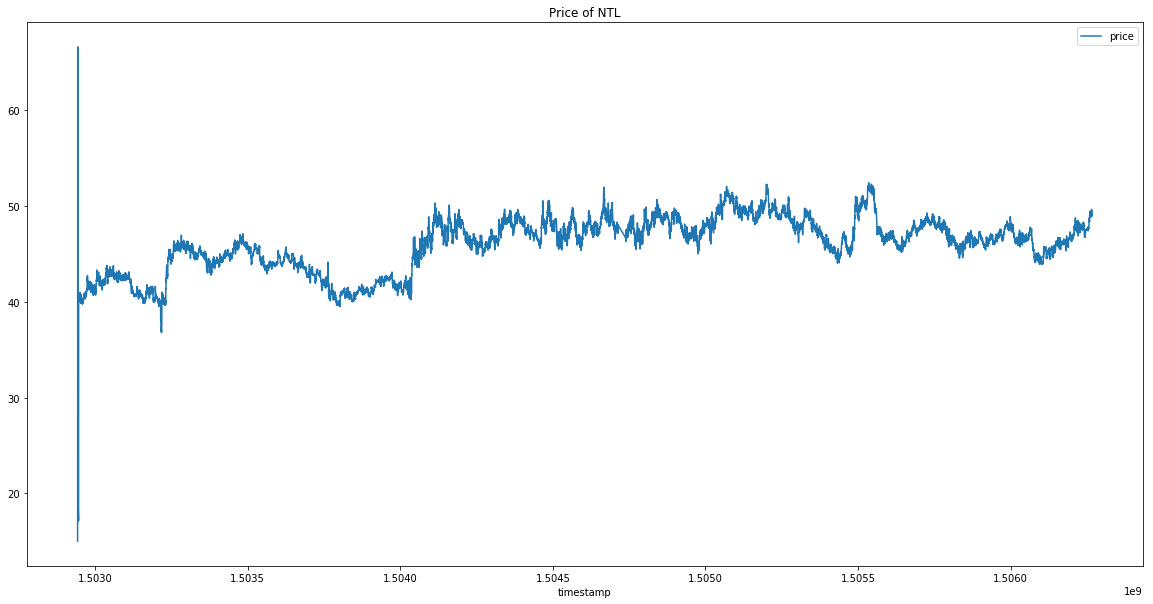

In [29]:
res.plot(y='price', x='timestamp', title="Price of NTL", figsize=(20, 10))

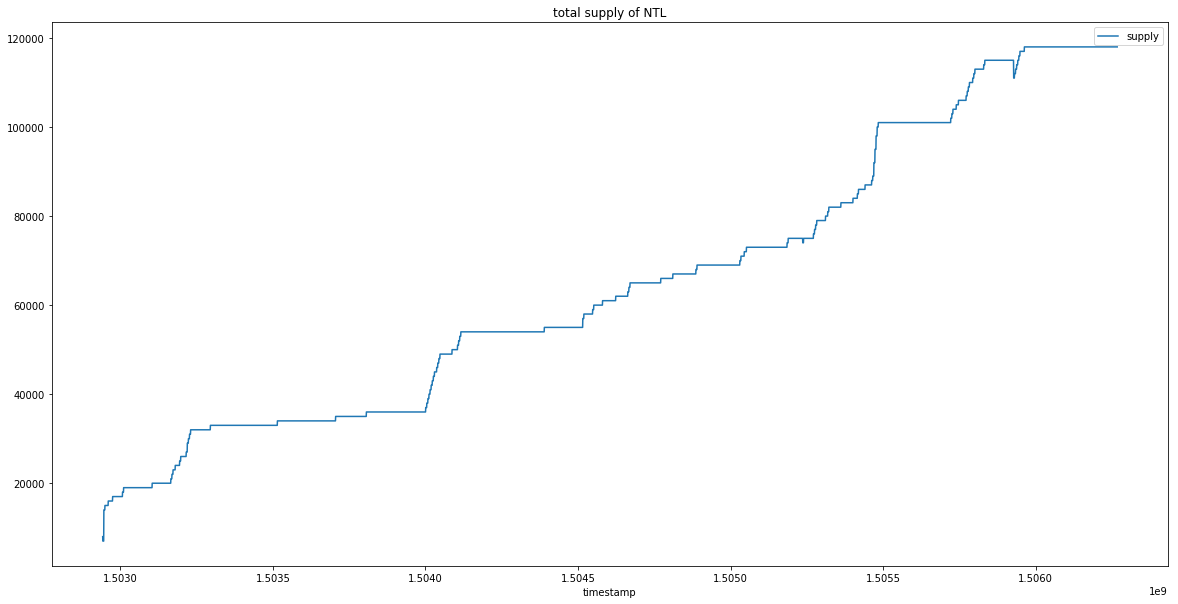

In [30]:
res.plot(y='supply', x='timestamp', title="total supply of NTL", figsize=(20, 10))

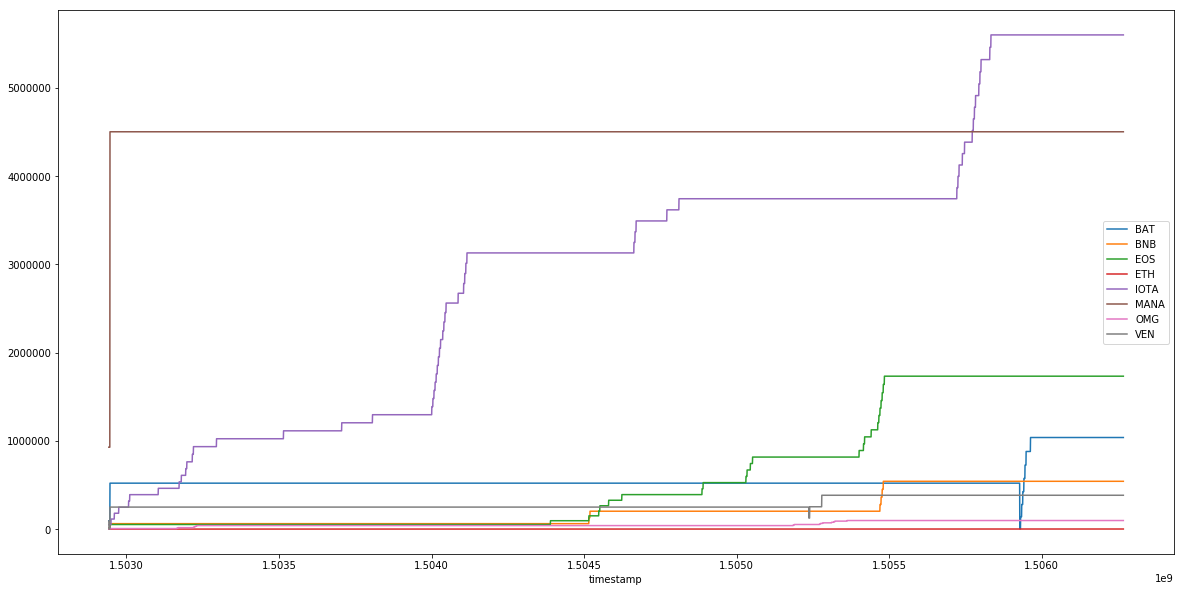

In [31]:
res.drop(columns=['price', 'supply']).plot(x='timestamp', figsize=(20, 10))

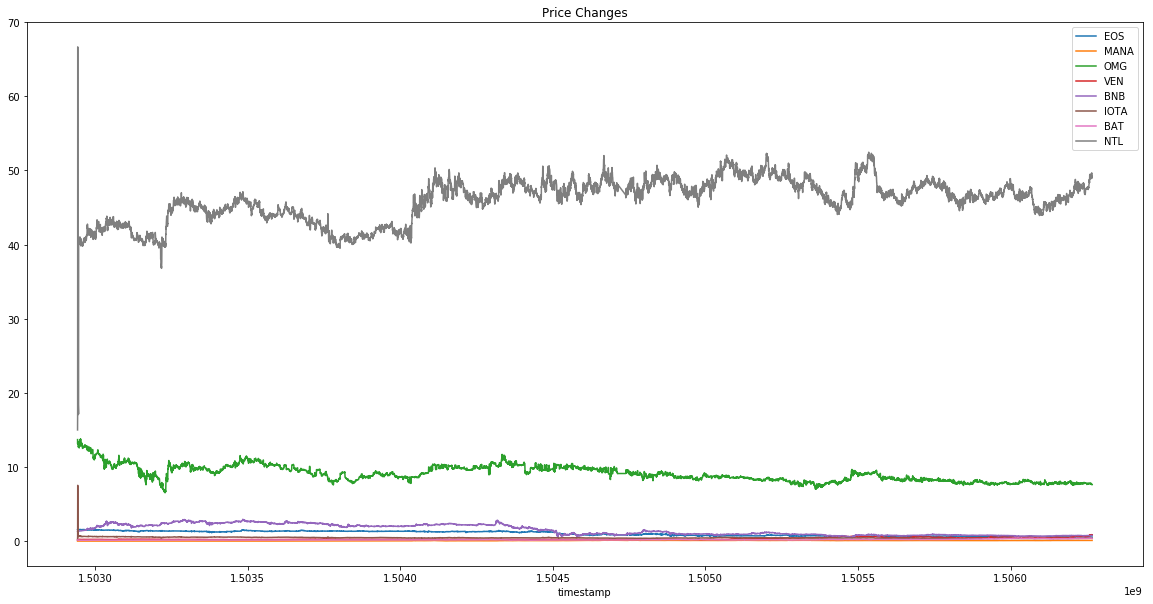

In [32]:
pd.merge(m,
         pd.DataFrame(dict(NTL=res['price'], timestamp=res['timestamp'])),
         on='timestamp').drop(columns=['ETH']).plot(x='timestamp', title="Price Changes", figsize=(20, 10))

In [33]:
m.describe()

,EOS,timestamp,MANA,OMG,VEN,BNB,IOTA,ETH,BAT
count,11022.000000,1.102200e+04,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000,11022.000000
mean,1.012053,1.504604e+09,0.065702,9.082596,0.339573,1.521508,0.459192,307.204804,0.199970
std,0.334062,9.635453e+05,0.037275,1.075108,0.134563,0.709074,0.096970,37.771487,0.063545
min,0.482895,1.502942e+09,0.013272,6.526780,0.165545,0.503544,0.301110,193.100000,0.128794
25%,0.679737,1.503767e+09,0.017794,8.205073,0.243386,0.855845,0.408065,283.010000,0.160320
50%,0.956240,1.504592e+09,0.078798,8.915736,0.261581,1.250860,0.448055,301.225000,0.175064
75%,1.338159,1.505443e+09,0.097047,9.852690,0.466032,2.201847,0.497293,331.245000,0.217466
max,1.583040,1.506267e+09,0.140380,13.793944,0.883354,2.956131,7.532500,394.320000,0.439605
